In [1]:
!which python
!pwd

/home/ebeyerle/micromamba/envs/tmgb/bin/python
/media/ebeyerle/seagate/frenkel/ellipsoid/GB/nvt/GB_3_5_2_1/anneal/notebooks


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from scipy import spatial
#import deeptime
import os
import torch
import jacobian
import constraints
#import pyemma
print(os.getcwd())

/media/ebeyerle/seagate/frenkel/ellipsoid/GB/nvt/GB_3_5_2_1/anneal/notebooks


In [3]:
params = {'legend.fontsize': 25,
          'figure.figsize': (8, 6),
         'axes.labelsize': 30,
         'axes.titlesize':25,
         'xtick.labelsize':25,'ytick.labelsize':25,
         'axes.linewidth':4,
         'xtick.major.width':3,'ytick.major.width':3,
         'xtick.minor.width':1,'ytick.minor.width':1,
         'xtick.major.size':5,'ytick.major.size':5,
         'xtick.minor.size':3,'ytick.minor.size':3,
         'xtick.direction':'in','ytick.direction':'in'
         }
plt.rcParams.update(params)

In [4]:
def quat2rot(quat):
    w = quat[:,0]
    x = quat[:,1]
    y = quat[:,2]
    z = quat[:,3]
    rot = np.array([
        [1 - 2 * y**2 - 2 * z**2, 2 * x * y + 2 * w * z, 2 * x * z - 2 * w * y],
        [2 * x * y - 2 * w * z, 1 - 2 * x**2 - 2 * z**2, 2 * y * z + 2 * w * x],
        [ 2 * x * z + 2 * w * y, 2 * y * z - 2 * w * x, 1 - 2 * x**2 - 2 * y**2]
    ])
    return rot

def nop(quats, n):
    dp = np.dot(n, np.matmul(n, quat2rot(quats)))
    S = 0.5 * ((3 * dp * dp) - 1).mean()
    return S

def calc_Q(quats, d = np.array([1, 0, 0])):
    from scipy import spatial
    Q_list = []
    d_list = []
    S_list = []
    for k, quat in enumerate(quats):
        u = np.matmul(spatial.transform.Rotation.from_quat(quat).as_matrix(), d)
        Q = np.zeros((3, 3))
        for i in range(u.shape[0]):
            Q += (1.5 * np.outer(u[i,:], u[i,:])) - 0.5 * np.eye(3)
        _, tmp = np.linalg.eigh(Q / u.shape[0])
        d = tmp[:,-1]
        Q_list.append(Q)
        d_list.append(d)
        S_list.append(_[-1])
    Q_list = np.array(Q_list)
    d_list = np.array(d_list)
    S_list = np.array(S_list)
    return Q_list, d_list, S_list

def rot_from_quat(q, r):
    q_s = q[:,0]
    q_v = q[:,1:].ravel()
    
    r_rotated = (q_s * q_s - np.dot(q_v, q_v)) * r + 2 * q_s * (np.cross(q_v, r)) + 2 * (np.dot(q_v, r)) * q_v
    return r_rotated

# coordination number for molecules parallel to the director axis
def C_parallel(ftraj, n, boxl, r_cut = 3.0):
    N = ftraj.shape[1]
    C = np.zeros(ftraj.shape[0])
    for i in range(N):
        #if i % 10 == 0: print(i)
        for j in range(N):
            if i == j:
                pass
            else:
                rij = abs(((ftraj[:,i,:] - ftraj[:,j,:]) * n).sum(1))
                rij = rij - boxl * np.rint(2 * rij/boxl)
                C += (1 - (rij / r_cut)**6) / (1 - (rij / r_cut)**12)
    return C / N

# coordination number for molecules perpendicular to the director axis
def C_perp_new(ftraj, n, boxl, r_cut = 3.0):
    N = ftraj.shape[1]
    C = np.zeros(ftraj.shape[0])
    for i in range(N):
        #if i % 10 == 0: print(i)
        for j in range(N):
            if i == j: pass
            tmp = ftraj[:,i,:] - ftraj[:,j,:]
            rij = np.linalg.norm(tmp, axis = 1) - (tmp * n).sum(1)
            rij = rij - boxl * np.rint(2 * rij/boxl)
            C += (1 - (rij / r_cut)**6) / (1 - (rij / r_cut)**12)
    return C / N

# PCA for a biased trajectory

def biased_PCA(data, weights):
    whitened_data = (data - data.mean(0)) / data.std(0)
    weighted_data = data * np.sqrt((weights[:, None] / weights.sum()))
    covar = np.matmul(weighted_data.T, weighted_data)
    eigvals, eigvecs = np.linalg.eigh(covar)
    PCs = np.matmul(data, eigvecs)
    return covar, eigvals, eigvecs, PCs

def linear_encoding(Q):
    neuron_num1 = Q.shape[0]
    neuron_num2 = Q.shape[1]
    device = torch.device("cpu") #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = torch.nn.Sequential(torch.nn.Linear(Q.shape[0], Q.shape[1], bias=False))
    model[0].weight = torch.nn.Parameter(torch.tensor(Q.T))
    return model

def identity_transformation(input_shape, output_shape = None):
    '''
    Transform the input numpy array into a torch tensor that can be automatically differentiated 
    '''
    if output_shape == None: output_shape = input_shape
    Q = torch.eye(input_shape, m = output_shape)
    neuron_num1 = Q.shape[0]
    neuron_num2 = Q.shape[1]
    device = torch.device("cpu") #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = torch.nn.Sequential(torch.nn.Linear(Q.shape[0], Q.shape[1], bias=False))
    model[0].weight = torch.nn.Parameter(torch.tensor(Q.T))
    return model

In [5]:
directories = []

directories.append('../T_1.5_rho_0.35/long/')

In [6]:
b = 1.0 / 1.5

In [7]:
timestep = 0.15
big_colvars = []
colvars_list = []
for counter, d in enumerate(directories):
    print(d)
    directory = d

    colvars = np.load(directory + '/no_C_perp_colvar.npy')[::5]
    nrg = np.loadtxt(directory + '/e.txt')[::5]
    weights = np.ones(len(colvars))

    if counter == 0:
        big_colvars = colvars[:len(weights)]
        big_weights = weights
        big_nrg = nrg
    else:
        big_colvars = np.vstack([colvars[:len(weights)], big_colvars])
        big_weights = np.concatenate([weights, big_weights])
        big_nrg = np.concatenate([nrg, big_nrg])
        
    colvars_list.append(colvars[:len(weights)])

../T_1.5_rho_0.35/long/


/tmp/ipykernel_2243898/437179321.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model[0].weight = torch.nn.Parameter(torch.tensor(Q.T))
/tmp/ipykernel_2243898/906513855.py:42: RuntimeWarning: divide by zero encountered in log
  fes  = -np.log(histo).T


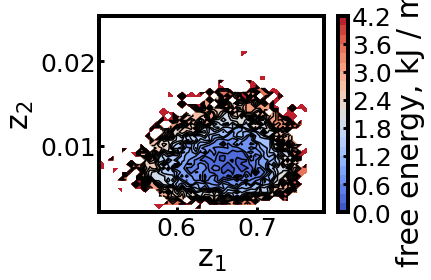

/tmp/ipykernel_2243898/906513855.py:64: RuntimeWarning: invalid value encountered in true_divide
  RC=np.divide(hist_RC[0],hist[0])


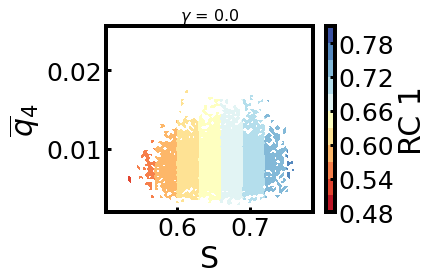

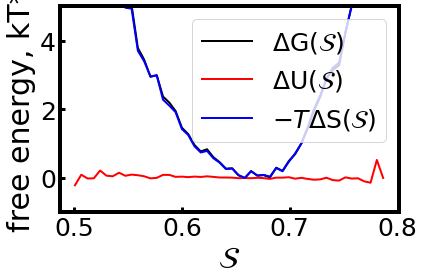

/tmp/ipykernel_2243898/906513855.py:101: RuntimeWarning: invalid value encountered in true_divide
  RC=np.divide(hist_RC[0],hist[0])


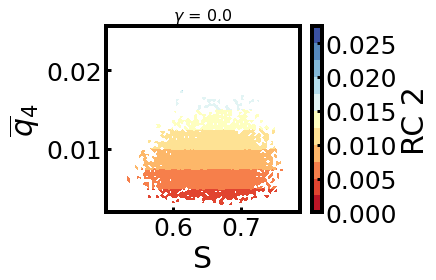

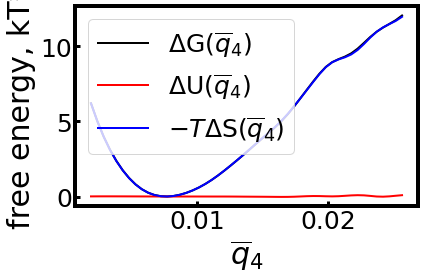

In [8]:
labels_list = ['S', 'P-F', r'$\overline{q}_4$', r'$\overline{q}_6$']

IB = identity_transformation(colvars.shape[1])

data = np.column_stack([big_colvars[:,0], big_colvars[:,-2]])
IB = identity_transformation(data.shape[1])
torch_data = torch.Tensor(data)
torch_data.requires_grad = True

z_mean, grad_list = jacobian.torch_jacobian_1d(torch_data, IB.forward(torch_data), all_inputs = True)

path = '/media/ebeyerle/seagate/frenkel/ellipsoid/GB/nvt/GB_3_5_2_1/anneal/T_1.5_rho_0.35/'
PATH = path

x = data[:,0]
y = data[:,1]

nreps = 1
seed = 0
bandwidth = "1e-1"
lr = 0.000100
nn = 16
gamma = 0.0
z1_bar_list = []
z2_bar_list = []
tensor_weights = torch.Tensor(big_weights)
output_thermo = True
aux_loss, G11, U11, S11, G22, U22, S22 = constraints.variational(torch_data, 
                                                                         z_mean, big_nrg, 
                                                                         bins = 50, bandwidth = 0.001, 
                                                                         output_thermo = output_thermo,
                                                                         b = b, weights = tensor_weights)
z = z_mean.detach().numpy()



hist = np.histogram2d(z[:,0],z[:,1],bins = 50, weights = big_weights)
histo = hist[0] / hist[0].sum()
xbins = (hist[1][:-1] + hist[1][1:]) / 2
ybins = (hist[2][:-1] + hist[2][1:]) / 2

fes  = -np.log(histo).T
fes = fes - fes.min()

kT = 1.
xx, yy = np.meshgrid(xbins, ybins)
im = plt.contourf(xx, yy, kT * fes, levels = 25, cmap = 'coolwarm')
plt.contour(xx, yy, kT * fes, levels = 25, colors = 'k')
cbar = plt.colorbar(im)
cbar.set_label('free energy, kJ / mol')
plt.xlabel(r"z$_1$")
plt.ylabel(r"z$_2$")
plt.tight_layout()
#plt.savefig(prefix + '_latent_space_fes.pdf', dpi = 300)
plt.show()
plt.close()


hist=np.histogram2d(x,y,bins=100)
hist_RC=np.histogram2d(x,y,bins=[hist[1],hist[2]], weights = z[:,0])

fig, ax = plt.subplots()

RC=np.divide(hist_RC[0],hist[0])

im=ax.contourf(RC.T, extent=[hist_RC[1][0],hist_RC[1][-1],hist_RC[2][0],hist_RC[2][-1]],levels=10,
                    cmap='RdYlBu')
cb1 = fig.colorbar(im,ax=ax)
cb1.set_label('RC 1')

plt.xlabel(r"S")
plt.ylabel(r"$\overline{q}_4$")
plt.title(r'$\gamma$ = ' + str(gamma), fontsize = 16)
plt.tight_layout()
#plt.savefig(prefix + '_RC_projection1.pdf', dpi = 300)
plt.show()
plt.close()

zbins = np.linspace(z[:,0].min() - 1e-9, z[:,0].max() + 1e-9, len(U11))
plt.plot(zbins, G11.detach().numpy() / b, lw = 2, c = 'k', label = r'$\Delta$G($\mathcal{S}$)')
plt.plot(zbins, U11.detach().numpy() / b, lw = 2, c = 'r', label = r'$\Delta$U($\mathcal{S}$)')
plt.plot(zbins, S11.detach().numpy() / b, lw = 2, c = 'b', label = r'$-T\Delta$S($\mathcal{S}$)')
#plt.axvline(z[:,0].min() + 0.5 * z[:,0].std(), lw =2, c = 'grey', ls = '--')
#plt.axvline(z[:,0].max() - 0.5 * z[:,0].std(), lw =2, c = 'grey', ls = '--')  
plt.legend()
plt.xlabel(r'$\mathcal{S}$')
plt.ylabel('free energy, kT*')
plt.ylim((-1,5))
#plt.ylim((-50, 50))
plt.tight_layout()
#plt.savefig('figures/dSz_point_free_energy_profile_gamma_' + str(gamma) + '.pdf', dpi = 300)
plt.show()
plt.close()


hist=np.histogram2d(x,y,bins=100)
hist_RC=np.histogram2d(x,y,bins=[hist[1],hist[2]], weights = z[:,1])

fig, ax = plt.subplots()

RC=np.divide(hist_RC[0],hist[0])

im=ax.contourf(RC.T, extent=[hist_RC[1][0],hist_RC[1][-1],hist_RC[2][0],hist_RC[2][-1]],levels=10,
                    cmap='RdYlBu')
cb1 = fig.colorbar(im,ax=ax)
cb1.set_label('RC 2')

plt.xlabel(r"S")
plt.ylabel(r"$\overline{q}_4$")
plt.title(r'$\gamma$ = ' + str(gamma), fontsize = 16)
plt.tight_layout()
#plt.savefig(prefix + '_RC_projection2.pdf', dpi = 300)
plt.show()
plt.close()

zbins = np.linspace(z[:,1].min() - 1e-9, z[:,1].max() + 1e-9, len(U22))
plt.plot(zbins, G22.detach().numpy() / b, lw = 2, c = 'k', label = r'$\Delta$G($\overline{q}_4$)')
plt.plot(zbins, U22.detach().numpy() / b, lw = 2, c = 'r', label = r'$\Delta$U($\overline{q}_4$)')
plt.plot(zbins, S22.detach().numpy() / b, lw = 2, c = 'b', label = r'$-T\Delta$S($\overline{q}_4$)')
#plt.axvline(z[:,1].min() + 0.5 * z[:,1].std(), lw =2, c = 'grey', ls = '--')
#plt.axvline(z[:,1].max() - 0.5 * z[:,1].std(), lw =2, c = 'grey', ls = '--')                    
plt.legend()
plt.xlabel(r'$\overline{q}_4$')
plt.ylabel('free energy, kT*')
#plt.ylim((-50, 50))

plt.tight_layout()
#plt.savefig('figures/dSz_point_free_energy_profile_gamma_' + str(gamma) + '.pdf', dpi = 300)
plt.show()
plt.close()

In [8]:
b = 1.0 / 1.

In [10]:
directories = []
for i in [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]:
    directories.append('../T_1.0_rho_%s/' % i)
    #directories.append('../T_1.77_rho_0.35/2/')
    #directories.append('../T_1.77_rho_0.35/3/')

In [11]:
labels_list = ['S', 'P-F', 'C perp', 'C parallel', r'$\overline{q}_4$', r'$\overline{q}_6$']

../T_1.8_rho_0.35/
1901


/tmp/ipykernel_2932106/437179321.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model[0].weight = torch.nn.Parameter(torch.tensor(Q.T))
/tmp/ipykernel_2932106/4007989452.py:63: RuntimeWarning: divide by zero encountered in log
  fes  = -np.log(histo).T


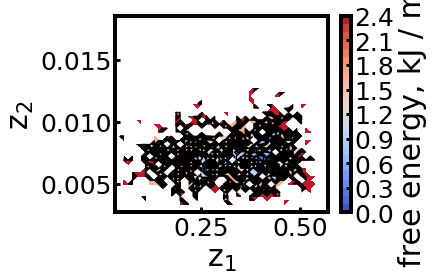

/tmp/ipykernel_2932106/4007989452.py:85: RuntimeWarning: invalid value encountered in true_divide
  RC=np.divide(hist_RC[0],hist[0])


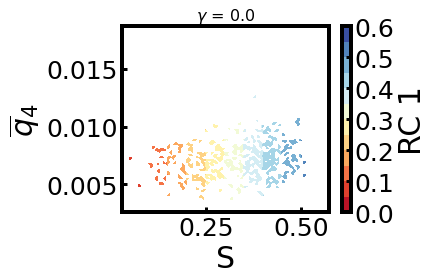

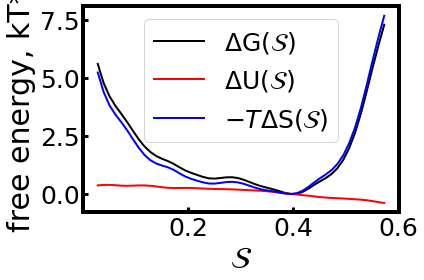

/tmp/ipykernel_2932106/4007989452.py:121: RuntimeWarning: invalid value encountered in true_divide
  RC=np.divide(hist_RC[0],hist[0])


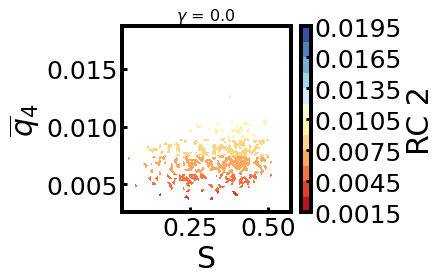

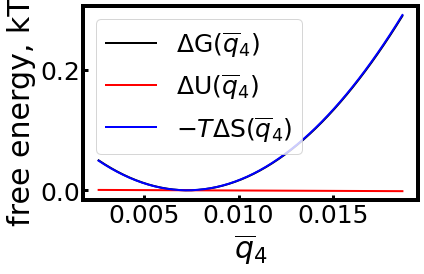

In [11]:
timestep = 0.15
big_colvars = []
colvars_list = []
rho_list = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]
q4_list = []
for counter, d in enumerate(directories):
    print(d)
    directory = d

    colvars = np.load(directory + '/new_C_perp_colvar.npy')[500:][::5]
    nrg = np.loadtxt(directory + '/e.txt')[500:][::5]
    weights = np.ones(len(colvars))

    length = np.min([len(nrg), len(weights), len(colvars)])
    print(length)
    

    big_colvars = colvars[:length]
    big_weights = weights[:length]
    big_nrg = nrg[:length]
    
    IB = identity_transformation(colvars.shape[1])
    
    data = np.column_stack([big_colvars[:,0], big_colvars[:,-2]])
    IB = identity_transformation(data.shape[1])
    torch_data = torch.Tensor(data)
    torch_data.requires_grad = True
    
    z_mean, grad_list = jacobian.torch_jacobian_1d(torch_data, IB.forward(torch_data), all_inputs = True)
    
    x = data[:,0]
    y = data[:,1]
    
    nreps = 1
    seed = 0
    bandwidth = "1e-1"
    lr = 0.000100
    nn = 16
    gamma = 0.0
    z1_bar_list = []
    z2_bar_list = []
    tensor_weights = torch.Tensor(big_weights)
    output_thermo = True
    aux_loss, G11, U11, S11, G22, U22, S22 = constraints.variational(torch_data, 
                                                                             z_mean, big_nrg, 
                                                                             bins = 50, bandwidth = 0.02, 
                                                                             output_thermo = output_thermo,
                                                                             b = b, weights = tensor_weights)
    z = z_mean.detach().numpy()


    q4_list.append(z[:,1].mean())

    hist = np.histogram2d(z[:,0],z[:,1],bins = 50, weights = big_weights)
    histo = hist[0] / hist[0].sum()
    xbins = (hist[1][:-1] + hist[1][1:]) / 2
    ybins = (hist[2][:-1] + hist[2][1:]) / 2

    fes  = -np.log(histo).T
    fes = fes - fes.min()

    kT = 1.
    xx, yy = np.meshgrid(xbins, ybins)
    im = plt.contourf(xx, yy, kT * fes, levels = 25, cmap = 'coolwarm')
    plt.contour(xx, yy, kT * fes, levels = 25, colors = 'k')
    cbar = plt.colorbar(im)
    cbar.set_label('free energy, kJ / mol')
    plt.xlabel(r"z$_1$")
    plt.ylabel(r"z$_2$")
    plt.tight_layout()
    #plt.savefig(prefix + '_latent_space_fes.pdf', dpi = 300)
    plt.show()
    plt.close()


    hist=np.histogram2d(x,y,bins=100)
    hist_RC=np.histogram2d(x,y,bins=[hist[1],hist[2]], weights = z[:,0])

    fig, ax = plt.subplots()

    RC=np.divide(hist_RC[0],hist[0])

    im=ax.contourf(RC.T, extent=[hist_RC[1][0],hist_RC[1][-1],hist_RC[2][0],hist_RC[2][-1]],levels=10,
                        cmap='RdYlBu')
    cb1 = fig.colorbar(im,ax=ax)
    cb1.set_label('RC 1')

    plt.xlabel(r"S")
    plt.ylabel(r"$\overline{q}_4$")
    plt.title(r'$\gamma$ = ' + str(gamma), fontsize = 16)
    plt.tight_layout()
    #plt.savefig(prefix + '_RC_projection1.pdf', dpi = 300)
    plt.show()
    plt.close()

    zbins = np.linspace(z[:,0].min() - 1e-9, z[:,0].max() + 1e-9, len(U11))
    plt.plot(zbins, G11.detach().numpy() / b, lw = 2, c = 'k', label = r'$\Delta$G($\mathcal{S}$)')
    plt.plot(zbins, U11.detach().numpy() / b, lw = 2, c = 'r', label = r'$\Delta$U($\mathcal{S}$)')
    plt.plot(zbins, S11.detach().numpy() / b, lw = 2, c = 'b', label = r'$-T\Delta$S($\mathcal{S}$)')
    #plt.axvline(z[:,0].min() + 0.5 * z[:,0].std(), lw =2, c = 'grey', ls = '--')
    #plt.axvline(z[:,0].max() - 0.5 * z[:,0].std(), lw =2, c = 'grey', ls = '--')  
    plt.legend()
    plt.xlabel(r'$\mathcal{S}$')
    plt.ylabel('free energy, kT*')
    #plt.ylim((-50, 50))
    plt.tight_layout()
    #plt.savefig('figures/dSz_point_free_energy_profile_gamma_' + str(gamma) + '.pdf', dpi = 300)
    plt.show()
    plt.close()


    hist=np.histogram2d(x,y,bins=100)
    hist_RC=np.histogram2d(x,y,bins=[hist[1],hist[2]], weights = z[:,1])

    fig, ax = plt.subplots()

    RC=np.divide(hist_RC[0],hist[0])

    im=ax.contourf(RC.T, extent=[hist_RC[1][0],hist_RC[1][-1],hist_RC[2][0],hist_RC[2][-1]],levels=10,
                        cmap='RdYlBu')
    cb1 = fig.colorbar(im,ax=ax)
    cb1.set_label('RC 2')

    plt.xlabel(r"S")
    plt.ylabel(r"$\overline{q}_4$")
    plt.title(r'$\gamma$ = ' + str(gamma), fontsize = 16)
    plt.tight_layout()
    #plt.savefig(prefix + '_RC_projection2.pdf', dpi = 300)
    plt.show()
    plt.close()

    zbins = np.linspace(z[:,1].min() - 1e-9, z[:,1].max() + 1e-9, len(U22))
    plt.plot(zbins, G22.detach().numpy() / b, lw = 2, c = 'k', label = r'$\Delta$G($\overline{q}_4$)')
    plt.plot(zbins, U22.detach().numpy() / b, lw = 2, c = 'r', label = r'$\Delta$U($\overline{q}_4$)')
    plt.plot(zbins, S22.detach().numpy() / b, lw = 2, c = 'b', label = r'$-T\Delta$S($\overline{q}_4$)')
    #plt.axvline(z[:,1].min() + 0.5 * z[:,1].std(), lw =2, c = 'grey', ls = '--')
    #plt.axvline(z[:,1].max() - 0.5 * z[:,1].std(), lw =2, c = 'grey', ls = '--')                    
    plt.legend()
    plt.xlabel(r'$\overline{q}_4$')
    plt.ylabel('free energy, kT*')
    #plt.ylim((-50, 50))

    plt.tight_layout()
    #plt.savefig('figures/dSz_point_free_energy_profile_gamma_' + str(gamma) + '.pdf', dpi = 300)
    plt.show()
    plt.close()

In [9]:
plt.plot(z[100:,0])

NameError: name 'z' is not defined

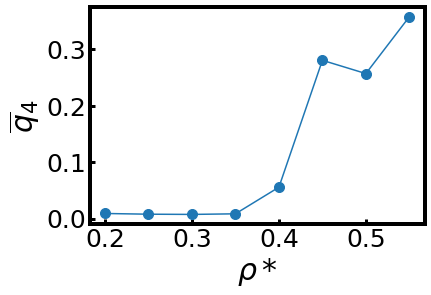

In [16]:
plt.plot(rho_list, q4_list, marker = 'o', markersize = 10)
plt.xlabel(r'$\rho*$')
plt.ylabel(r'$\overline{q}_4$')
plt.show()
plt.close()

0.1
../T_0.1_rho_0.35/


/tmp/ipykernel_92330/437179321.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model[0].weight = torch.nn.Parameter(torch.tensor(Q.T))
/tmp/ipykernel_92330/124201534.py:73: RuntimeWarning: divide by zero encountered in log
  fes  = -np.log(histo).T


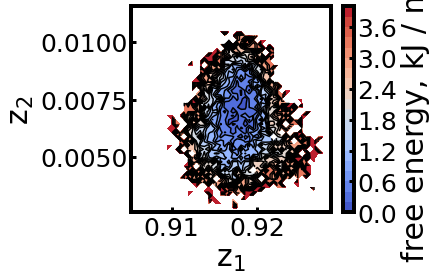

/tmp/ipykernel_92330/124201534.py:95: RuntimeWarning: invalid value encountered in true_divide
  RC=np.divide(hist_RC[0],hist[0])


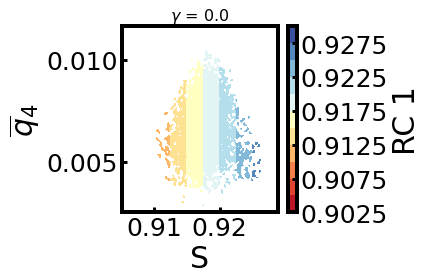

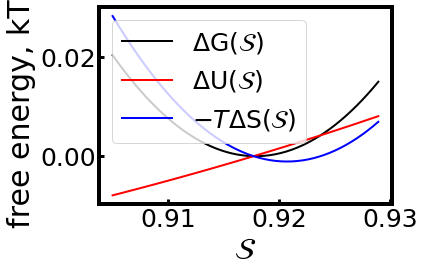

/tmp/ipykernel_92330/124201534.py:132: RuntimeWarning: invalid value encountered in true_divide
  RC=np.divide(hist_RC[0],hist[0])


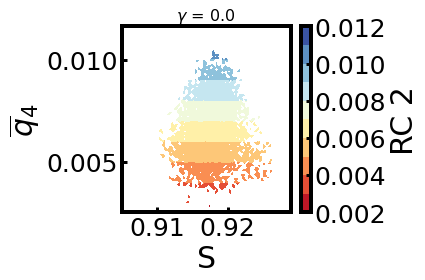

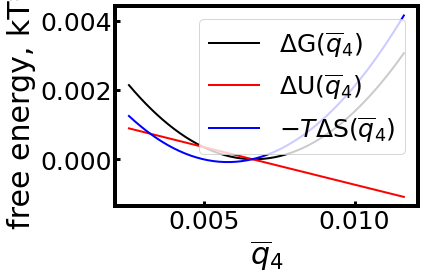

0.5
../T_0.5_rho_0.35/


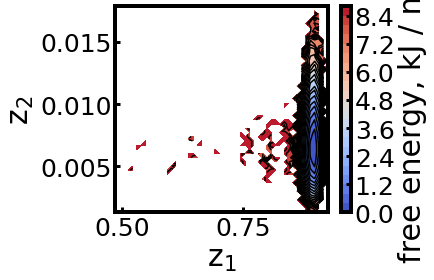

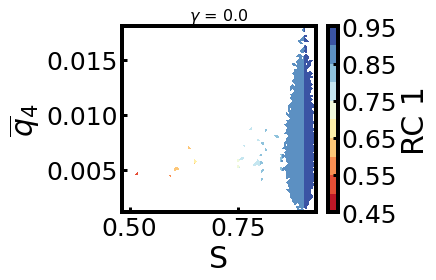

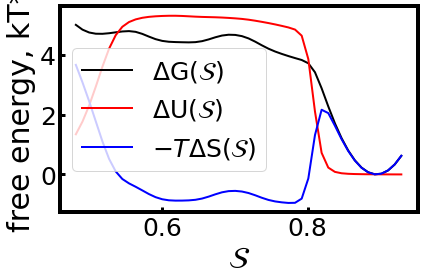

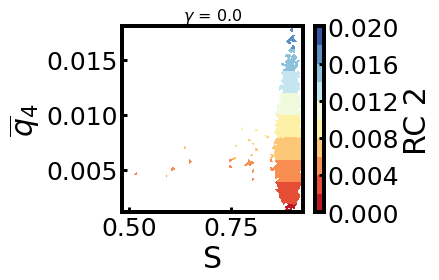

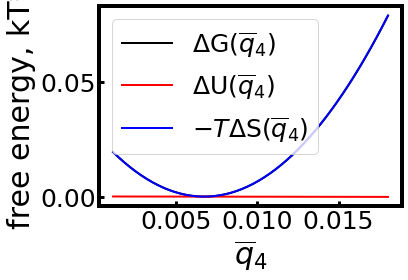

1.0
../T_1.0_rho_0.35/


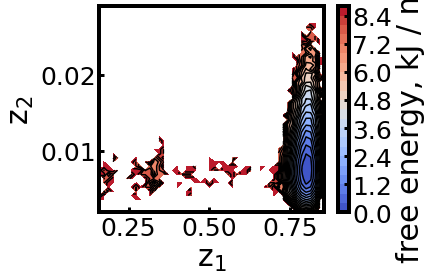

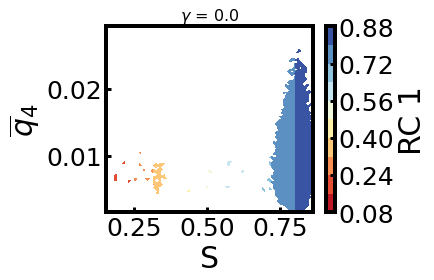

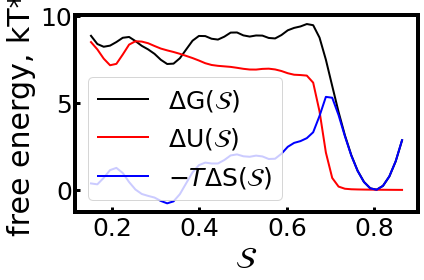

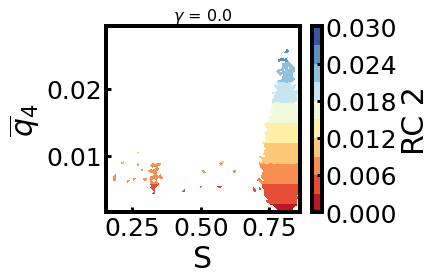

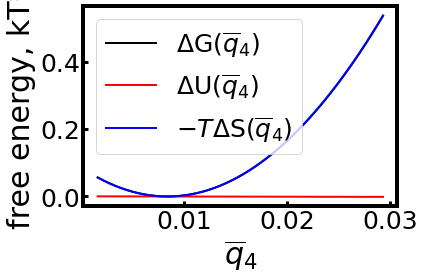

1.5
../T_1.5_rho_0.35/


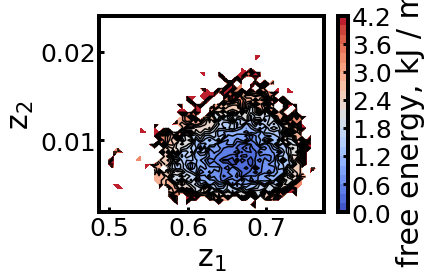

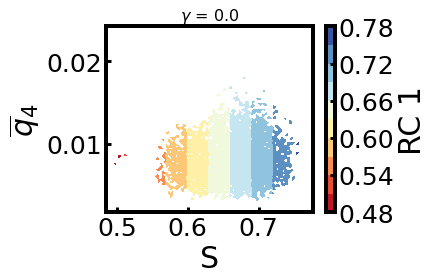

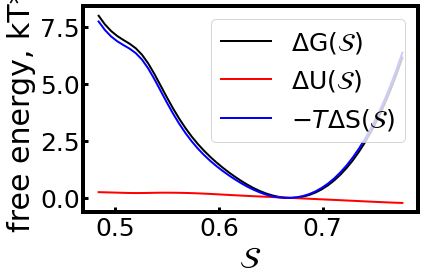

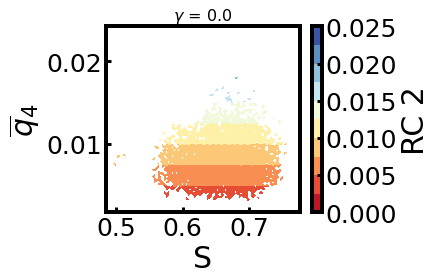

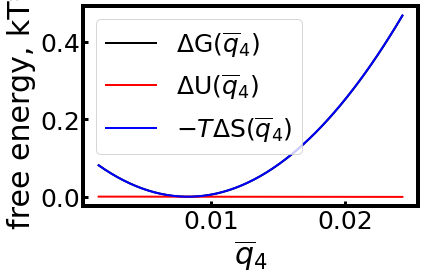

1.6
../T_1.6_rho_0.35/


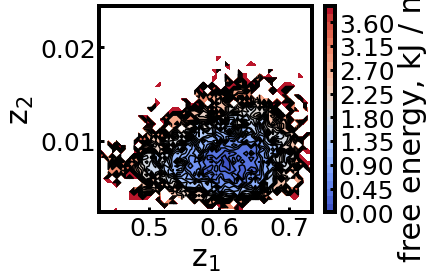

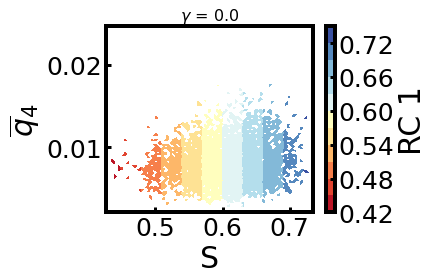

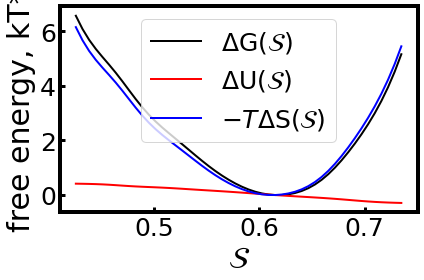

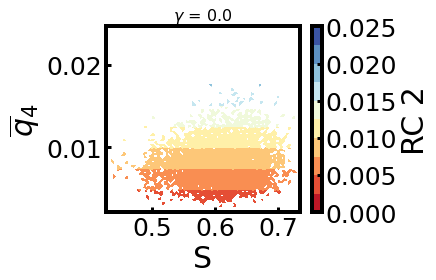

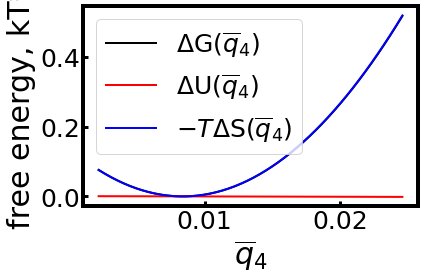

1.7
../T_1.7_rho_0.35/


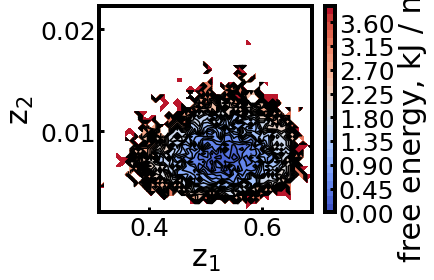

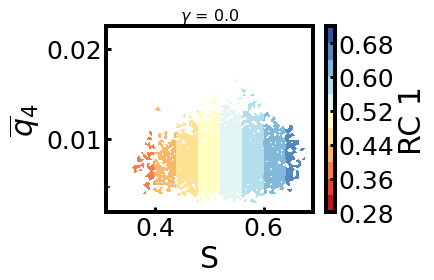

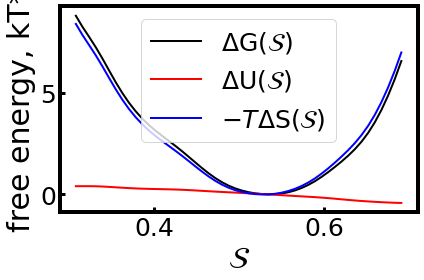

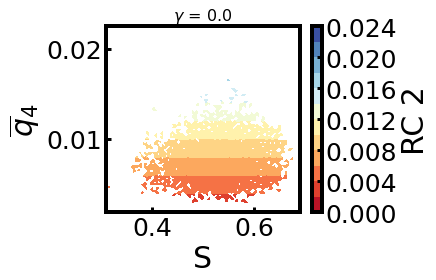

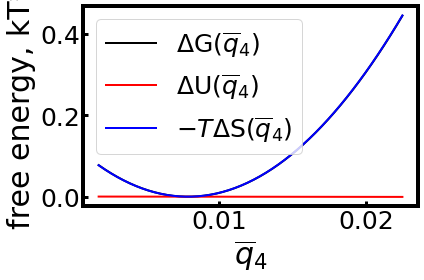

1.8
../T_1.8_rho_0.35/


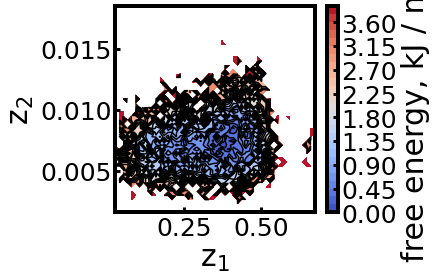

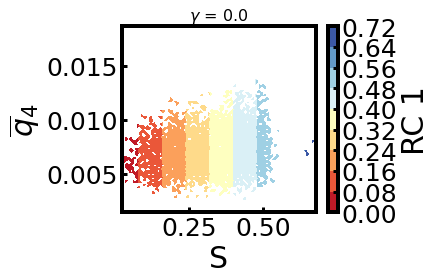

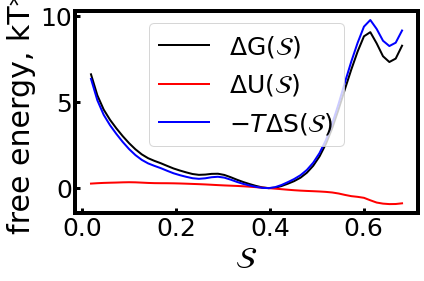

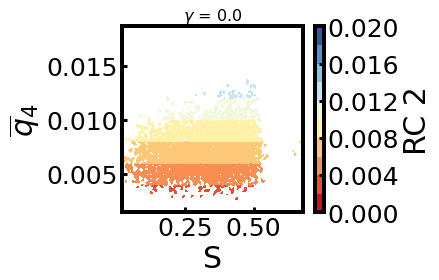

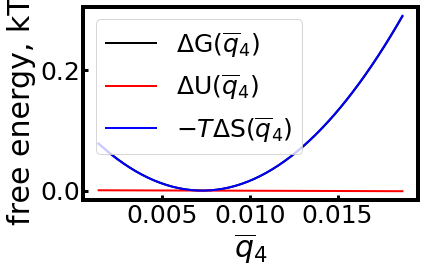

1.9
../T_1.9_rho_0.35/


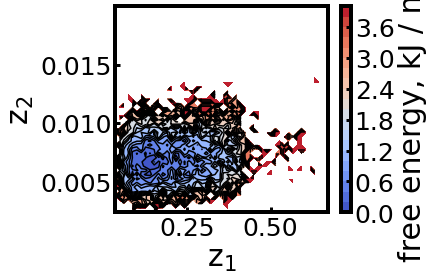

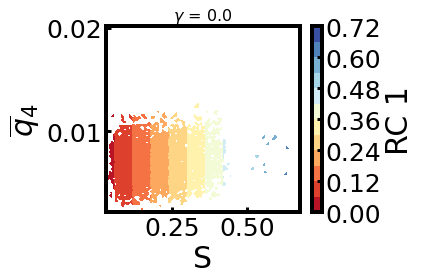

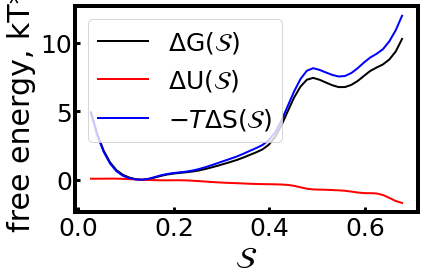

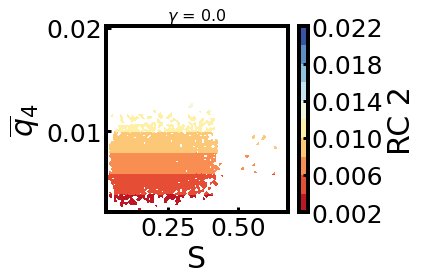

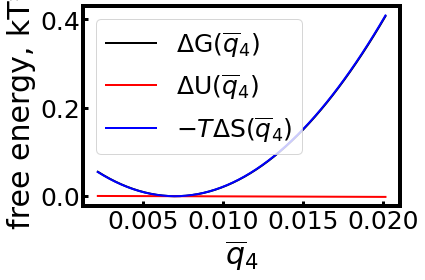

2.0
../T_2.0_rho_0.35/


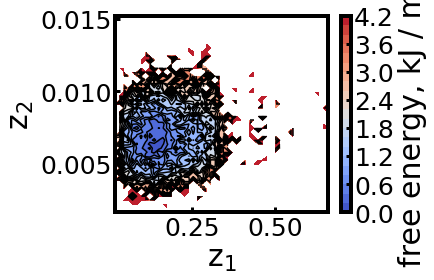

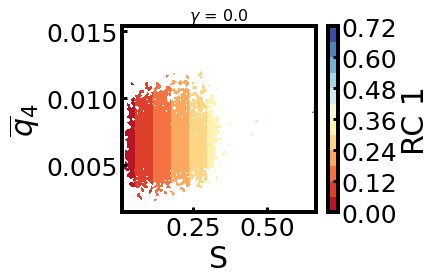

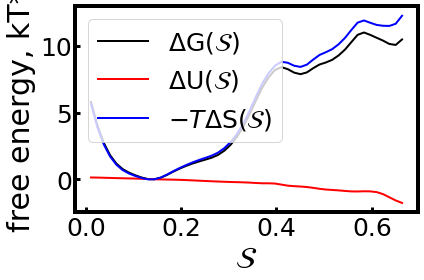

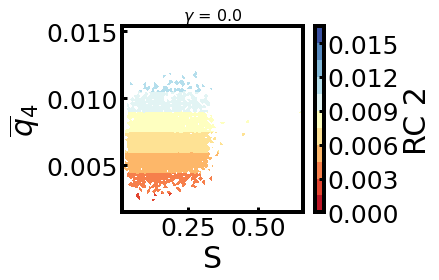

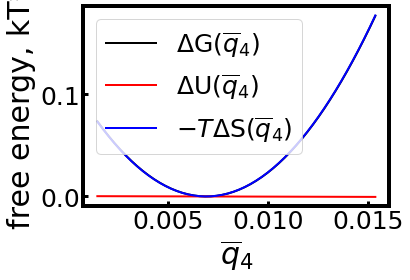

2.1
../T_2.1_rho_0.35/


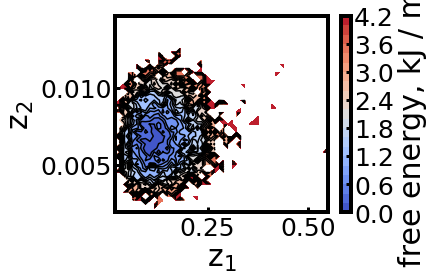

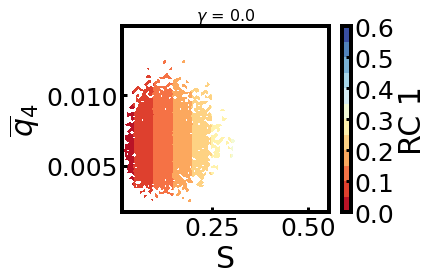

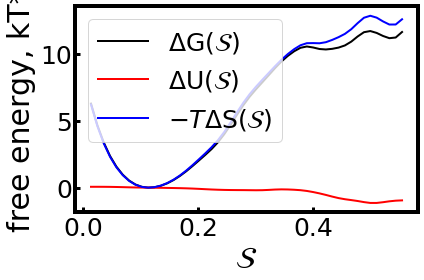

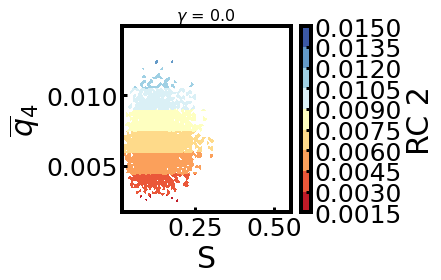

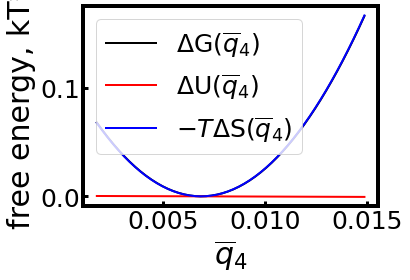

2.4
../T_2.4_rho_0.35/


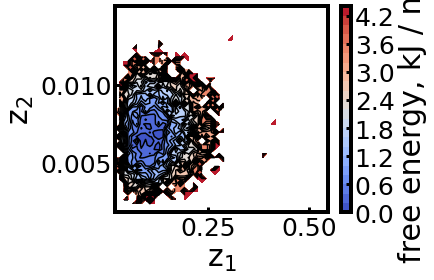

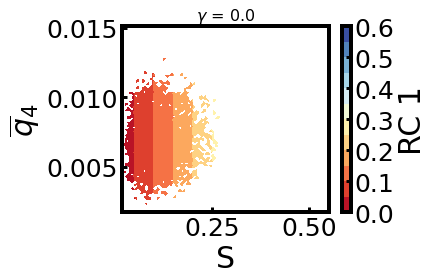

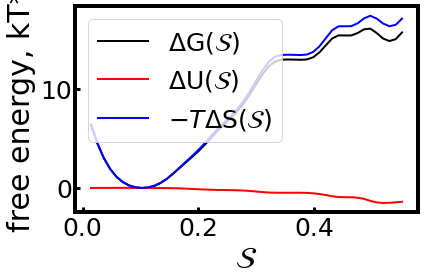

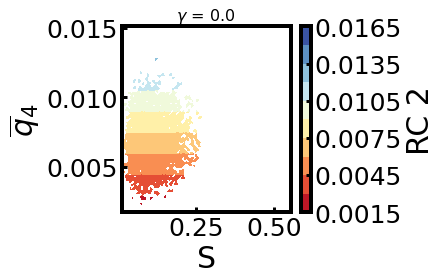

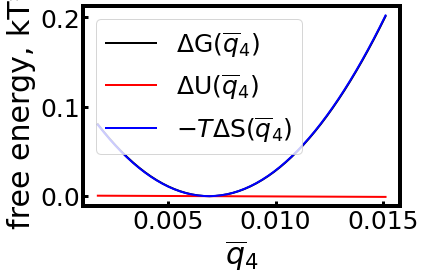

In [11]:
for T in [0.1, 0.5, 1.0, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.4]:

    print(T)
    directories = []
    directories.append('../T_%s_rho_0.35/' % T)
    b = 1.0 / T
    timestep = 0.15
    big_colvars = []
    colvars_list = []
    for counter, d in enumerate(directories):
        print(d)
        directory = d

        colvars = np.load(directory + '/new_C_perp_colvar.npy')
        nrg = np.loadtxt(directory + '/e.txt')
        
        length = np.min([len(colvars), len(nrg)])
        weights = np.ones(length)

        if counter == 0:
            big_colvars = colvars[:length]
            big_weights = weights[:length]
            big_nrg = nrg[:length]
        else:
            big_colvars = np.vstack([colvars[:length], big_colvars])
            big_weights = np.concatenate([weights[:length], big_weights])
            big_nrg = np.concatenate([nrg[:length], big_nrg])

        colvars_list.append(colvars[:length])
        
    labels_list = ['S', 'P-F', r'C$_{||}$', r'C$_{\perp}$', r'$\overline{q}_4$',
              r'$\overline{q}_6$']

    IB = identity_transformation(colvars.shape[1])

    data = np.column_stack([big_colvars[:,0], big_colvars[:,-2]])
    IB = identity_transformation(data.shape[1])
    torch_data = torch.Tensor(data)
    torch_data.requires_grad = True

    z_mean, grad_list = jacobian.torch_jacobian_1d(torch_data, IB.forward(torch_data), all_inputs = True)

    path = '/media/ebeyerle/seagate/frenkel/ellipsoid/GB/nvt/GB_3_5_2_1/anneal/T_%s_rho_0.35/' % T
    PATH = path

    x = data[:,0]
    y = data[:,1]

    nreps = 1
    seed = 0
    bandwidth = "1e-1"
    lr = 0.000100
    nn = 16
    gamma = 0.0
    z1_bar_list = []
    z2_bar_list = []
    tensor_weights = torch.Tensor(big_weights)
    output_thermo = True
    aux_loss, G11, U11, S11, G22, U22, S22 = constraints.variational(torch_data, 
                                                                             z_mean, big_nrg, 
                                                                             bins = 50, bandwidth = 0.02, 
                                                                             output_thermo = output_thermo,
                                                                             b = b, weights = tensor_weights)
    z = z_mean.detach().numpy()



    hist = np.histogram2d(z[:,0],z[:,1],bins = 50, weights = big_weights)
    histo = hist[0] / hist[0].sum()
    xbins = (hist[1][:-1] + hist[1][1:]) / 2
    ybins = (hist[2][:-1] + hist[2][1:]) / 2

    fes  = -np.log(histo).T
    fes = fes - fes.min()

    kT = 1.
    xx, yy = np.meshgrid(xbins, ybins)
    im = plt.contourf(xx, yy, kT * fes, levels = 25, cmap = 'coolwarm')
    plt.contour(xx, yy, kT * fes, levels = 25, colors = 'k')
    cbar = plt.colorbar(im)
    cbar.set_label('free energy, kJ / mol')
    plt.xlabel(r"z$_1$")
    plt.ylabel(r"z$_2$")
    plt.tight_layout()
    #plt.savefig(prefix + '_latent_space_fes.pdf', dpi = 300)
    plt.show()
    plt.close()


    hist=np.histogram2d(x,y,bins=100)
    hist_RC=np.histogram2d(x,y,bins=[hist[1],hist[2]], weights = z[:,0])

    fig, ax = plt.subplots()

    RC=np.divide(hist_RC[0],hist[0])

    im=ax.contourf(RC.T, extent=[hist_RC[1][0],hist_RC[1][-1],hist_RC[2][0],hist_RC[2][-1]],levels=10,
                        cmap='RdYlBu')
    cb1 = fig.colorbar(im,ax=ax)
    cb1.set_label('RC 1')

    plt.xlabel(r"S")
    plt.ylabel(r"$\overline{q}_4$")
    plt.title(r'$\gamma$ = ' + str(gamma), fontsize = 16)
    plt.tight_layout()
    #plt.savefig(prefix + '_RC_projection1.pdf', dpi = 300)
    plt.show()
    plt.close()

    zbins = np.linspace(z[:,0].min() - 1e-9, z[:,0].max() + 1e-9, len(U11))
    plt.plot(zbins, G11.detach().numpy() / b, lw = 2, c = 'k', label = r'$\Delta$G($\mathcal{S}$)')
    plt.plot(zbins, U11.detach().numpy() / b, lw = 2, c = 'r', label = r'$\Delta$U($\mathcal{S}$)')
    plt.plot(zbins, S11.detach().numpy() / b, lw = 2, c = 'b', label = r'$-T\Delta$S($\mathcal{S}$)')
    #plt.axvline(z[:,0].min() + 0.5 * z[:,0].std(), lw =2, c = 'grey', ls = '--')
    #plt.axvline(z[:,0].max() - 0.5 * z[:,0].std(), lw =2, c = 'grey', ls = '--')  
    plt.legend()
    plt.xlabel(r'$\mathcal{S}$')
    plt.ylabel('free energy, kT*')
    #plt.ylim((-1,5))
    #plt.ylim((-50, 50))
    plt.tight_layout()
    #plt.savefig('figures/dSz_point_free_energy_profile_gamma_' + str(gamma) + '.pdf', dpi = 300)
    plt.show()
    plt.close()


    hist=np.histogram2d(x,y,bins=100)
    hist_RC=np.histogram2d(x,y,bins=[hist[1],hist[2]], weights = z[:,1])

    fig, ax = plt.subplots()

    RC=np.divide(hist_RC[0],hist[0])

    im=ax.contourf(RC.T, extent=[hist_RC[1][0],hist_RC[1][-1],hist_RC[2][0],hist_RC[2][-1]],levels=10,
                        cmap='RdYlBu')
    cb1 = fig.colorbar(im,ax=ax)
    cb1.set_label('RC 2')

    plt.xlabel(r"S")
    plt.ylabel(r"$\overline{q}_4$")
    plt.title(r'$\gamma$ = ' + str(gamma), fontsize = 16)
    plt.tight_layout()
    #plt.savefig(prefix + '_RC_projection2.pdf', dpi = 300)
    plt.show()
    plt.close()

    zbins = np.linspace(z[:,1].min() - 1e-9, z[:,1].max() + 1e-9, len(U22))
    plt.plot(zbins, G22.detach().numpy() / b, lw = 2, c = 'k', label = r'$\Delta$G($\overline{q}_4$)')
    plt.plot(zbins, U22.detach().numpy() / b, lw = 2, c = 'r', label = r'$\Delta$U($\overline{q}_4$)')
    plt.plot(zbins, S22.detach().numpy() / b, lw = 2, c = 'b', label = r'$-T\Delta$S($\overline{q}_4$)')
    #plt.axvline(z[:,1].min() + 0.5 * z[:,1].std(), lw =2, c = 'grey', ls = '--')
    #plt.axvline(z[:,1].max() - 0.5 * z[:,1].std(), lw =2, c = 'grey', ls = '--')                    
    plt.legend()
    plt.xlabel(r'$\overline{q}_4$')
    plt.ylabel('free energy, kT*')
    #plt.ylim((-50, 50))

    plt.tight_layout()
    #plt.savefig('figures/dSz_point_free_energy_profile_gamma_' + str(gamma) + '.pdf', dpi = 300)
    plt.show()
    plt.close()

0.5
../T_0.5_rho_0.35/


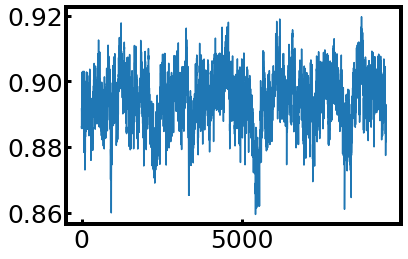

/tmp/ipykernel_2243898/437179321.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model[0].weight = torch.nn.Parameter(torch.tensor(Q.T))


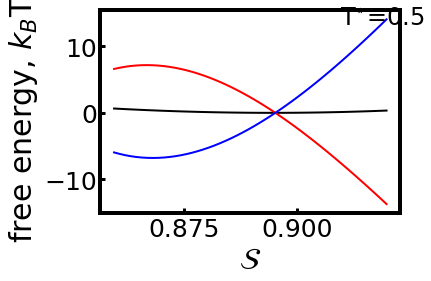

1.0
../T_1.0_rho_0.35/


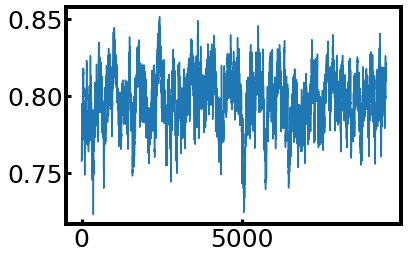

/tmp/ipykernel_2243898/437179321.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model[0].weight = torch.nn.Parameter(torch.tensor(Q.T))


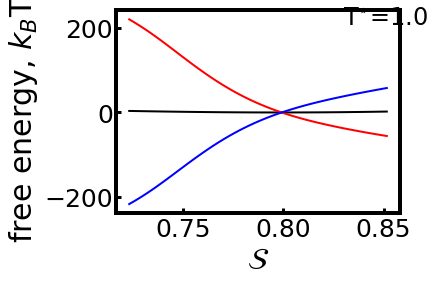

1.2
../T_1.2_rho_0.35/


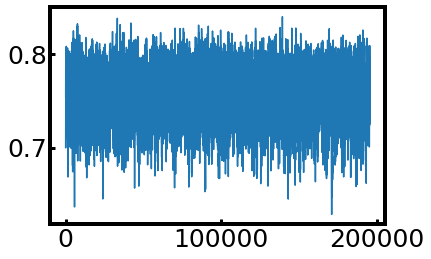

/tmp/ipykernel_2243898/437179321.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model[0].weight = torch.nn.Parameter(torch.tensor(Q.T))


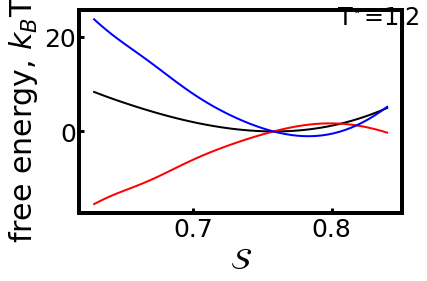

1.3
../T_1.3_rho_0.35/


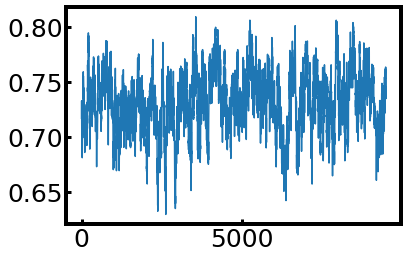

/tmp/ipykernel_2243898/437179321.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model[0].weight = torch.nn.Parameter(torch.tensor(Q.T))


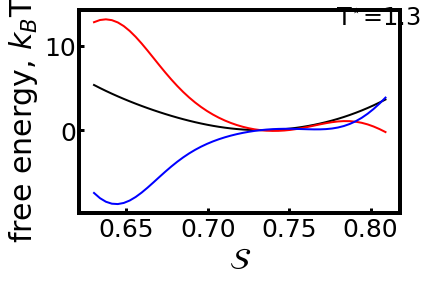

1.4
../T_1.4_rho_0.35/


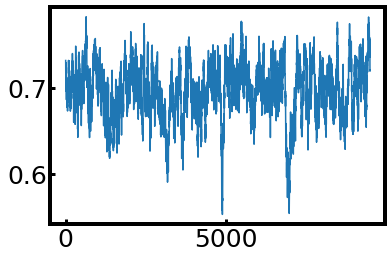

/tmp/ipykernel_2243898/437179321.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model[0].weight = torch.nn.Parameter(torch.tensor(Q.T))


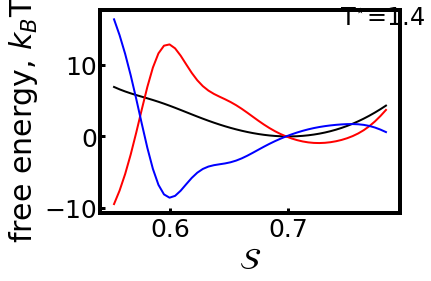

1.5
../T_1.5_rho_0.35/


ValueError: x and y can be no greater than 2D, but have shapes (0,) and (0, 1, 10001)

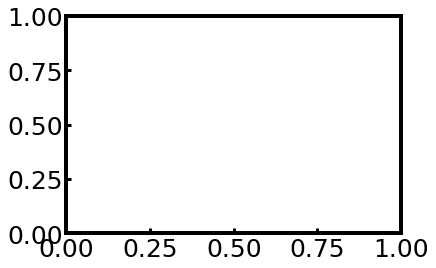

In [14]:
for T in [0.5, 1.0, 1.2, 1.3, 1.4, 1.5, 1.7, 1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.80, 2.0, 2.2, 2.4]:

    print(T)
    directories = []
    directories.append('../T_%s_rho_0.35/' % T)
    b = 1.0 / T
    timestep = 0.15
    big_colvars = []
    colvars_list = []
    for counter, d in enumerate(directories):
        print(d)
        directory = d

        colvars = np.load(directory + '/S.npy')[500:,None]
        plt.plot(colvars)
        plt.show()
        plt.close()
        nrg = np.loadtxt(directory + '/e.txt') * 343
        
        length = np.min([len(colvars), len(nrg)])
        weights = np.ones(length)

        if counter == 0:
            big_colvars = colvars[:length]
            big_weights = weights[:length]
            big_nrg = nrg[:length]
        else:
            big_colvars = np.vstack([colvars[:length], big_colvars])
            big_weights = np.concatenate([weights[:length], big_weights])
            big_nrg = np.concatenate([nrg[:length], big_nrg])

        colvars_list.append(colvars[:length])
        
    labels_list = ['S', 'P-F', r'C$_{||}$', r'C$_{\perp}$', r'$\overline{q}_4$',
              r'$\overline{q}_6$']

    IB = identity_transformation(colvars.shape[1])

    data = big_colvars
    IB = identity_transformation(data.shape[1])
    torch_data = torch.Tensor(data)
    torch_data.requires_grad = True

    z_mean, grad_list = jacobian.torch_jacobian_1d(torch_data, IB.forward(torch_data), all_inputs = True)

    path = '/media/ebeyerle/seagate/frenkel/ellipsoid/GB/nvt/GB_3_5_2_1/anneal/T_%s_rho_0.35/' % T
    PATH = path

    x = data[:,0]

    nreps = 1
    seed = 0
    bandwidth = "1e-1"
    lr = 0.000100
    nn = 16
    gamma = 0.0
    z1_bar_list = []
    z2_bar_list = []
    tensor_weights = torch.Tensor(big_weights)
    output_thermo = True
    aux_loss, G11, U11, S11 = constraints.variational(torch_data, 
                                                                 z_mean, big_nrg, 
                                                                 bins = 50, bandwidth = 0.02, 
                                                                 output_thermo = output_thermo,
                                                                 b = b, weights = tensor_weights)
    z = z_mean.detach().numpy()


    fig, ax = plt.subplots()
    zbins = np.linspace(z[:,0].min() - 1e-9, z[:,0].max() + 1e-9, len(U11))
    ax.plot(zbins, G11.detach().numpy() / b, lw = 2, c = 'k', label = r'$\Delta$G($\mathcal{S}$)')
    ax.plot(zbins, U11.detach().numpy() / b, lw = 2, c = 'r', label = r'$\Delta$U($\mathcal{S}$)')
    ax.plot(zbins, S11.detach().numpy() / b, lw = 2, c = 'b', label = r'$-T\Delta$S($\mathcal{S}$)')
    #plt.axvline(z[:,0].min() + 0.5 * z[:,0].std(), lw =2, c = 'grey', ls = '--')
    #plt.axvline(z[:,0].max() - 0.5 * z[:,0].std(), lw =2, c = 'grey', ls = '--')  
    #if T == 1.2:
    #    ax.legend(fontsize = 20, loc = 'upper right', framealpha = 0.25)
    ax.set_xlabel(r'$\mathcal{S}$')
    ax.set_ylabel(r'free energy, $k_B$T*')
    #plt.ylim((-1,5))
    #plt.ylim((-50, 50))
    if T >= 1.7:
        plt.text(0.05,0.925, r'T$^{\star}$=%s' % T, transform = ax.transAxes, fontsize = 24)
    else:
        plt.text(0.8,0.925, r'T$^{\star}$=%s' % T, transform = ax.transAxes, fontsize = 24)
    plt.tight_layout()
    plt.savefig('fes_S_T%s.pdf' % T, dpi = 300)
    plt.show()
    plt.close()

In [16]:
T_list = [0.2, 0.5, 1.0, 1.2, 1.5, 1.7, 1.8, 1.9, 2.0, 2.2, 2.4]
mean_S = np.zeros(len(T_list))
std_S = np.zeros(len(T_list))

for i, temperature in enumerate(T_list):

    S = np.load('thermomaps-gayberne/%sT/S.npy' % temperature)[100:]

    mean_S[i] = S.mean()
    std_S[i] = S.std()

In [17]:
tm_samples = np.load('nstep_100_bs_512_lr_0.01_samples_redo_short.npy')

100 512 0.01


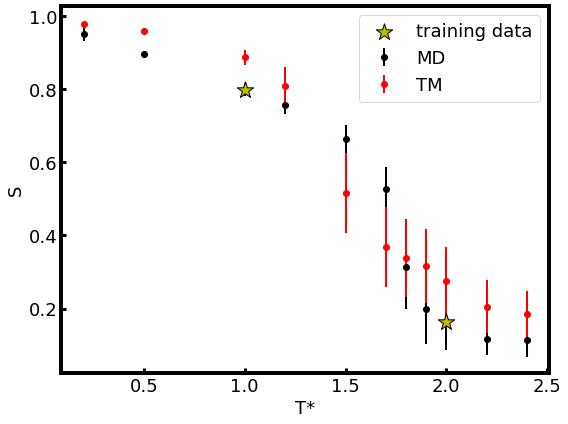

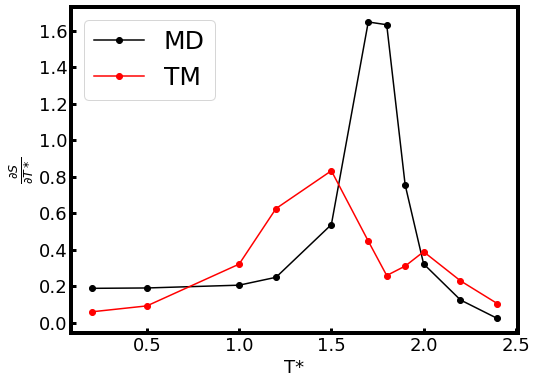

In [19]:
for nstep in [100]:
    for bs in [512]:
        for lr in [0.01]:
            print(nstep, bs, lr)

            try:
                mag = np.load('nstep_%s_bs_%s_lr_%smagnetization_redo_short.npy' % (nstep, bs, lr))
                plt.errorbar(T_list, mean_S, yerr = std_S, elinewidth = 2, marker = 'o', lw = 0,
                            capsize = 0, c = 'k', label = 'MD')
                plt.errorbar(mag[:,0], mag[:,1], yerr = mag[:,2], elinewidth = 2, marker = 'o', lw = 0,
                            capsize = 0, c = 'r', label = 'TM',)
                #mag_med = np.load('nstep_%s_bs_%s_lr_%s_magnetization_redo.npy' % (nstep, bs, lr))
                #plt.errorbar(mag_med[:,0], mag_med[:,1], yerr = mag_med[:,2], elinewidth = 2, marker = 'o', lw = 0,
                #            capsize = 5, c = 'b', label = 'two-point TM',)
                plt.scatter(T_list[2], mean_S[2], marker = '*', edgecolor = 'k', color = 'y', s = 300, zorder = 10)
                plt.scatter(T_list[-3], mean_S[-3], marker = '*', edgecolor = 'k', color = 'y', s = 300, zorder = 10,
                           label = 'training data')
                plt.legend(fontsize = 18)
                plt.xlabel('T*', size = 18)
                plt.ylabel('S', size = 18)
                plt.tick_params(labelsize = 18)
                plt.tight_layout()
                #plt.savefig('magnetization_tm_md_comparison.pdf', dpi = 300)
                plt.show()
                plt.close()
                
                plt.plot(T_list, -np.gradient(mean_S, T_list), marker = 'o', c = 'k', label = 'MD')
                plt.plot(mag[:,0], -np.gradient(mag[:,1], mag[:,0]), marker = 'o', c = 'r', label = 'TM')
                #plt.plot(mag_med[:,0], -np.gradient(mag_med[:,1], mag_med[:,0]), marker = 'o', c = 'b', label = 'more TM')
                plt.ylabel(r'$\frac{\partial S}{\partial T*}$', size = 18)
                plt.xlabel('T*', size = 18)
                plt.tick_params(labelsize = 18)
                plt.legend()
                plt.show()
                plt.close()
            except FileNotFoundError:
                pass

0.5
../T_0.5_rho_0.35/


/tmp/ipykernel_2243898/437179321.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model[0].weight = torch.nn.Parameter(torch.tensor(Q.T))


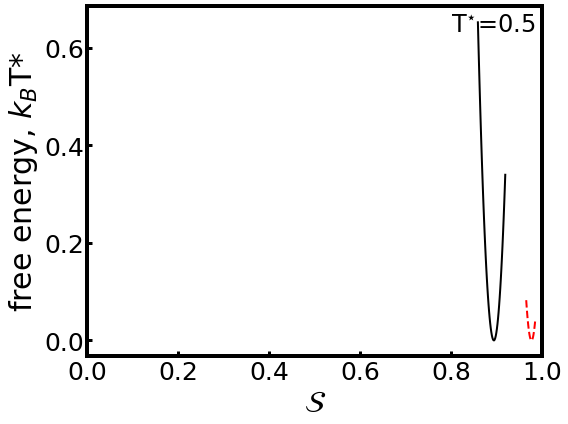

1.0
../T_1.0_rho_0.35/


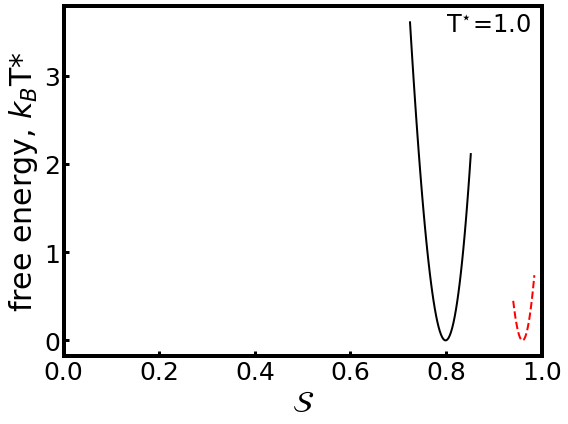

1.2
../T_1.2_rho_0.35/


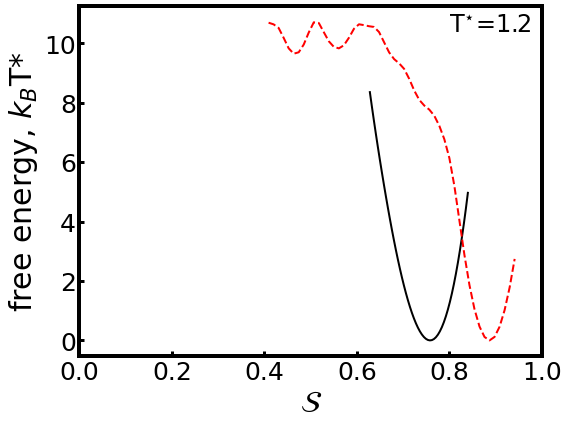

1.5
../T_1.5_rho_0.35/


RuntimeError: mat1 and mat2 shapes cannot be multiplied (0x10001 and 1x1)

In [20]:
# plot mean values as well for both MD and TM
for nstep in [100]:
    for bs in [512]:
        for lr in [0.01]:
            tm_samples = np.load('nstep_%s_bs_%s_lr_%s_samples_redo_short.npy' % (nstep, bs, lr))
            for i, T in enumerate([0.5, 1.0, 1.2, 1.5, 1.7, 1.8, 1.9, 2.0, 2.2, 2.4]):

                print(T)
                directories = []
                directories.append('../T_%s_rho_0.35/' % T)
                b = 1.0 / T
                timestep = 0.15
                big_colvars = []
                colvars_list = []
                for counter, d in enumerate(directories):
                    print(d)
                    directory = d

                    colvars_tm = tm_samples[i,:][:,None]
                    colvars_md = np.load(directory + '/S.npy')[1000:,None]
                    nrg_tm = np.loadtxt(directory + '/e.txt')[:len(colvars_tm)]
                    nrg_md = np.loadtxt(directory + '/e.txt')[:len(colvars_md)]

                    length = np.min([len(colvars_tm), len(nrg_tm)])
                    weights_tm = np.ones(length)

                    length = np.min([len(colvars_md), len(nrg_md)])
                    weights_md = np.ones(length)


                IB_tm = identity_transformation(colvars_tm.shape[1])
                IB_md = identity_transformation(colvars_md.shape[1])

                data_tm = colvars_tm
                data_md = colvars_md
                torch_data_tm = torch.Tensor(data_tm)
                torch_data_md = torch.Tensor(data_md)
                torch_data_tm.requires_grad = True
                torch_data_md.requires_grad = True

                z_mean_tm, grad_list_tm = jacobian.torch_jacobian_1d(torch_data_tm, IB_tm.forward(torch_data_tm), all_inputs = True)
                z_mean_md, grad_list_md = jacobian.torch_jacobian_1d(torch_data_md, IB_md.forward(torch_data_md), all_inputs = True)

                path = '/media/ebeyerle/seagate/frenkel/ellipsoid/GB/nvt/GB_3_5_2_1/anneal/T_%s_rho_0.35/' % T
                PATH = path

                #x = data[:,0]

                nreps = 1
                seed = 0
                bandwidth = "1e-1"
                lr = 0.000100
                nn = 16
                gamma = 0.0
                z1_bar_list = []
                z2_bar_list = []
                tensor_weights_tm = torch.Tensor(weights_tm)
                tensor_weights_md = torch.Tensor(weights_md)
                output_thermo = True
                aux_loss_tm, G11_tm, U11_tm, S11_tm = constraints.variational(torch_data_tm, 
                                                                             z_mean_tm, nrg_tm, 
                                                                             bins = 50, bandwidth = 0.02, 
                                                                             output_thermo = output_thermo,
                                                                             b = b, weights = tensor_weights_tm)
                z_tm = z_mean_tm.detach().numpy()

                aux_loss_md, G11_md, U11_md, S11_md = constraints.variational(torch_data_md, 
                                                                             z_mean_md, nrg_md, 
                                                                             bins = 50, bandwidth = 0.02, 
                                                                             output_thermo = output_thermo,
                                                                             b = b, weights = tensor_weights_md)
                z_md = z_mean_md.detach().numpy()


                fig, ax = plt.subplots()
                zbins_tm = np.linspace(z_tm[:,0].min() - 1e-9, z_tm[:,0].max() + 1e-9, len(U11_tm))
                zbins_md = np.linspace(z_md[:,0].min() - 1e-9, z_md[:,0].max() + 1e-9, len(U11_md))
                ax.plot(zbins_md, G11_md.detach().numpy() / b, lw = 2, c = 'k', label = r'$\Delta$G_{\text{MD}}($\mathcal{S}$)')
                ax.plot(zbins_tm, G11_tm.detach().numpy() / b, lw = 2, c = 'r', ls = '--', label = r'$\Delta$G_{\text{TM}}($\mathcal{S}$)')    
                #ax.plot(zbins, U11.detach().numpy() / b, lw = 2, c = 'r', label = r'$\Delta$U($\mathcal{S}$)')
                #ax.plot(zbins, S11.detach().numpy() / b, lw = 2, c = 'b', label = r'$-T\Delta$S($\mathcal{S}$)')
                #plt.axvline(z[:,0].min() + 0.5 * z[:,0].std(), lw =2, c = 'grey', ls = '--')
                #plt.axvline(z[:,0].max() - 0.5 * z[:,0].std(), lw =2, c = 'grey', ls = '--')  
                #if T == 1.2:
                #    ax.legend(fontsize = 20, loc = 'upper right', framealpha = 0.25)
                ax.set_xlabel(r'$\mathcal{S}$')
                ax.set_ylabel(r'free energy, $k_B$T*')
                #plt.ylim((-1,5))
                #plt.ylim((-50, 50))
                plt.xlim((0, 1))
                if T >= 1.7:
                    plt.text(0.05,0.925, r'T$^{\star}$=%s' % T, transform = ax.transAxes, fontsize = 24)
                else:
                    plt.text(0.8,0.925, r'T$^{\star}$=%s' % T, transform = ax.transAxes, fontsize = 24)
                plt.tight_layout()
                #plt.savefig('fes_S_T%s.pdf' % T, dpi = 300)
                plt.show()
                plt.close()

In [21]:
bins_md, hist_md = np.histogram(colvars_md, bins = 50)

0.5
../T_0.5_rho_0.35/


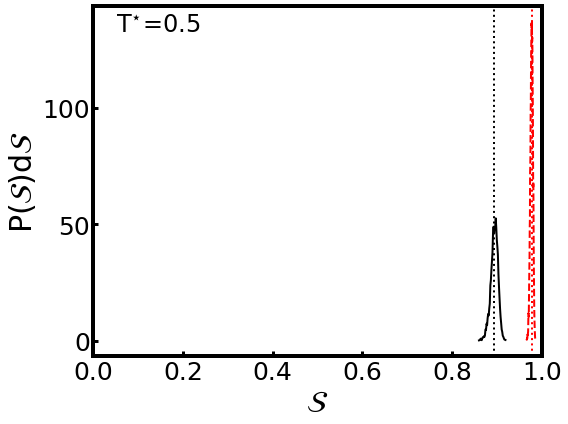

0.8943772676151709
0.9774522090443772
1.0
../T_1.0_rho_0.35/


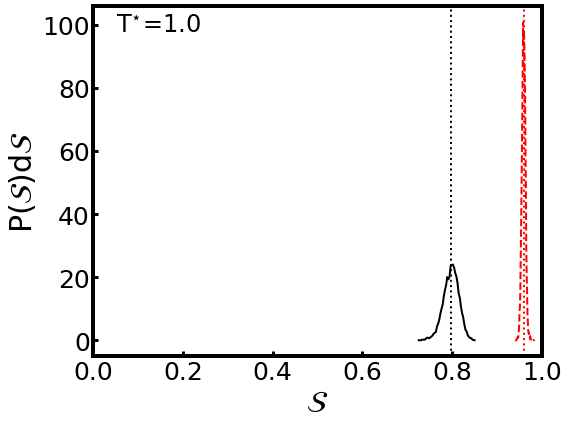

0.7977887435391695
0.9597333682304011
1.5
../T_1.5_rho_0.35/


/tmp/ipykernel_2243898/2782928653.py:38: RuntimeWarning: invalid value encountered in true_divide
  hist_md = hist_md / (hist_md.sum() * (bins_md[1] - bins_md[0]))


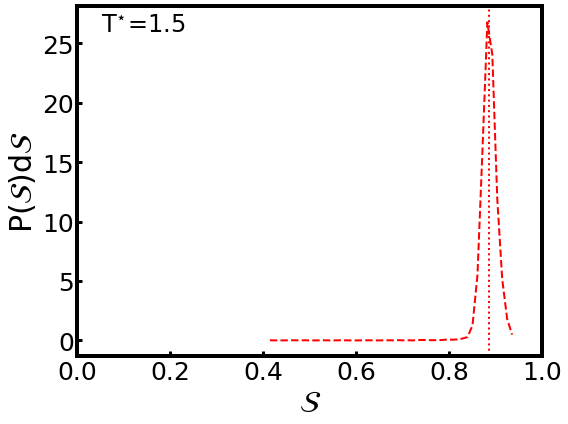

nan
0.8867341653580783
1.7
../T_1.7_rho_0.35/


/tmp/ipykernel_2243898/2782928653.py:38: RuntimeWarning: invalid value encountered in true_divide
  hist_md = hist_md / (hist_md.sum() * (bins_md[1] - bins_md[0]))


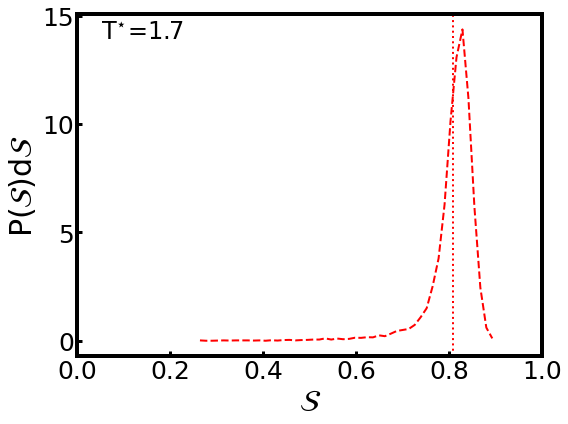

nan
0.8086856233120905
1.8
../T_1.8_rho_0.35/


/tmp/ipykernel_2243898/2782928653.py:38: RuntimeWarning: invalid value encountered in true_divide
  hist_md = hist_md / (hist_md.sum() * (bins_md[1] - bins_md[0]))


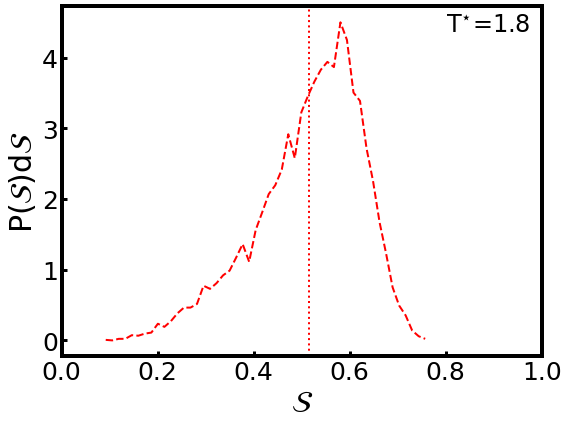

nan
0.5155635645789225
1.9
../T_1.9_rho_0.35/


/tmp/ipykernel_2243898/2782928653.py:38: RuntimeWarning: invalid value encountered in true_divide
  hist_md = hist_md / (hist_md.sum() * (bins_md[1] - bins_md[0]))


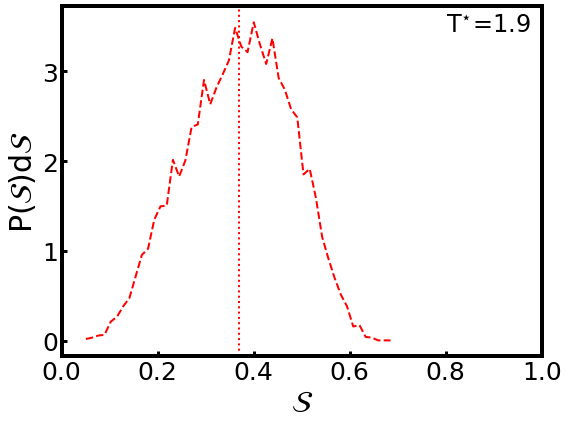

nan
0.36855389790460746
2.0
../T_2.0_rho_0.35/


/tmp/ipykernel_2243898/2782928653.py:38: RuntimeWarning: invalid value encountered in true_divide
  hist_md = hist_md / (hist_md.sum() * (bins_md[1] - bins_md[0]))


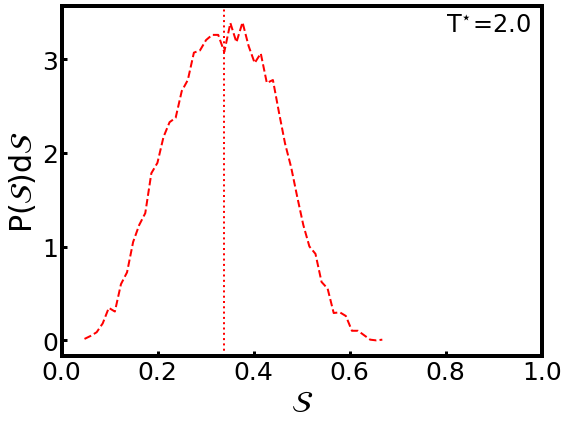

nan
0.3383112958398968
2.2
../T_2.2_rho_0.35/


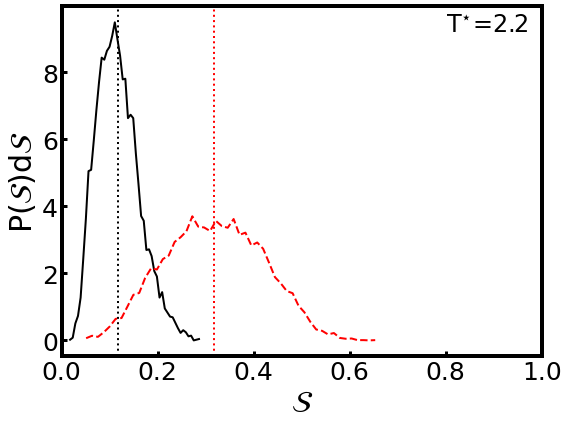

0.11745537680358442
0.3169512323563818
2.4
../T_2.4_rho_0.35/


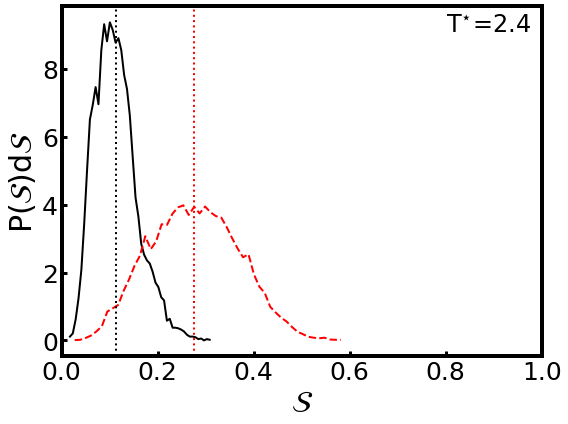

0.11292588819732167
0.2763926388823324


In [22]:
# plot mean values as well for both MD and TM
bins_md_list = []
bins_tm_list = []
hist_md_list = []
hist_tm_list = []
for nstep in [100]:
    for bs in [512]:
        for lr in [0.01]:
            tm_samples = np.load('nstep_%s_bs_%s_lr_%s_samples_redo_short.npy' % (nstep, bs, lr))
            for i, T in enumerate([0.5, 1.0, 1.5, 1.7, 1.8, 1.9, 2.0, 2.2, 2.4]):

                print(T)
                directories = []
                directories.append('../T_%s_rho_0.35/' % T)
                b = 1.0 / T
                timestep = 0.15
                big_colvars = []
                colvars_list = []
                for counter, d in enumerate(directories):
                    print(d)
                    directory = d

                    colvars_tm = tm_samples[i,:][:,None]
                    colvars_md = np.load(directory + '/S.npy')[1000:,None]
                    nrg_tm = np.loadtxt(directory + '/e.txt')[:len(colvars_tm)]
                    nrg_md = np.loadtxt(directory + '/e.txt')[:len(colvars_md)]

                    length = np.min([len(colvars_tm), len(nrg_tm)])
                    weights_tm = np.ones(length)

                    length = np.min([len(colvars_md), len(nrg_md)])
                    weights_md = np.ones(length)



                hist_md, bins_md = np.histogram(colvars_md, bins = 50)
                bins_md = (bins_md[1:] + bins_md[:-1]) / 2.
                hist_md = hist_md / (hist_md.sum() * (bins_md[1] - bins_md[0]))
                hist_tm, bins_tm = np.histogram(colvars_tm, bins = 50)
                bins_tm = (bins_tm[1:] + bins_tm[:-1]) / 2.
                hist_tm = hist_tm / (hist_tm.sum() * (bins_tm[1] - bins_tm[0]))
                
                bins_md_list.append(bins_md)
                bins_tm_list.append(bins_tm)
                hist_md_list.append(hist_md)
                hist_tm_list.append(hist_tm)
                
                fig, ax = plt.subplots()
                ax.plot(bins_md, hist_md, lw = 2, c = 'k')
                ax.plot(bins_tm, hist_tm, lw = 2, c = 'r', ls = '--')
                
                ax.axvline((hist_md * bins_md * (bins_md[1] - bins_md[0])).sum(), lw = 2, c = 'k', ls = ":")
                ax.axvline((hist_tm * bins_tm * (bins_tm[1] - bins_tm[0])).sum(), lw = 2, c = 'r', ls = ':')
                
                ax.set_xlabel(r'$\mathcal{S}$')
                ax.set_ylabel(r'P($\mathcal{S}$)d$\mathcal{S}$')
                #plt.ylim((-1,5))
                #plt.ylim((-50, 50))
                plt.xlim((0, 1))
                if T <= 1.7:
                    plt.text(0.05,0.925, r'T$^{\star}$=%s' % T, transform = ax.transAxes, fontsize = 24)
                else:
                    plt.text(0.8,0.925, r'T$^{\star}$=%s' % T, transform = ax.transAxes, fontsize = 24)
                plt.tight_layout()
                plt.savefig('prob_S_T%s.pdf' % T, dpi = 300)
                plt.show()
                plt.close()
                
                print((hist_md * bins_md * (bins_md[1] - bins_md[0])).sum())
                print((hist_tm * bins_tm * (bins_tm[1] - bins_tm[0])).sum())

In [11]:
import matplotlib.pyplot as plt

from matplotlib.transforms import ScaledTranslation

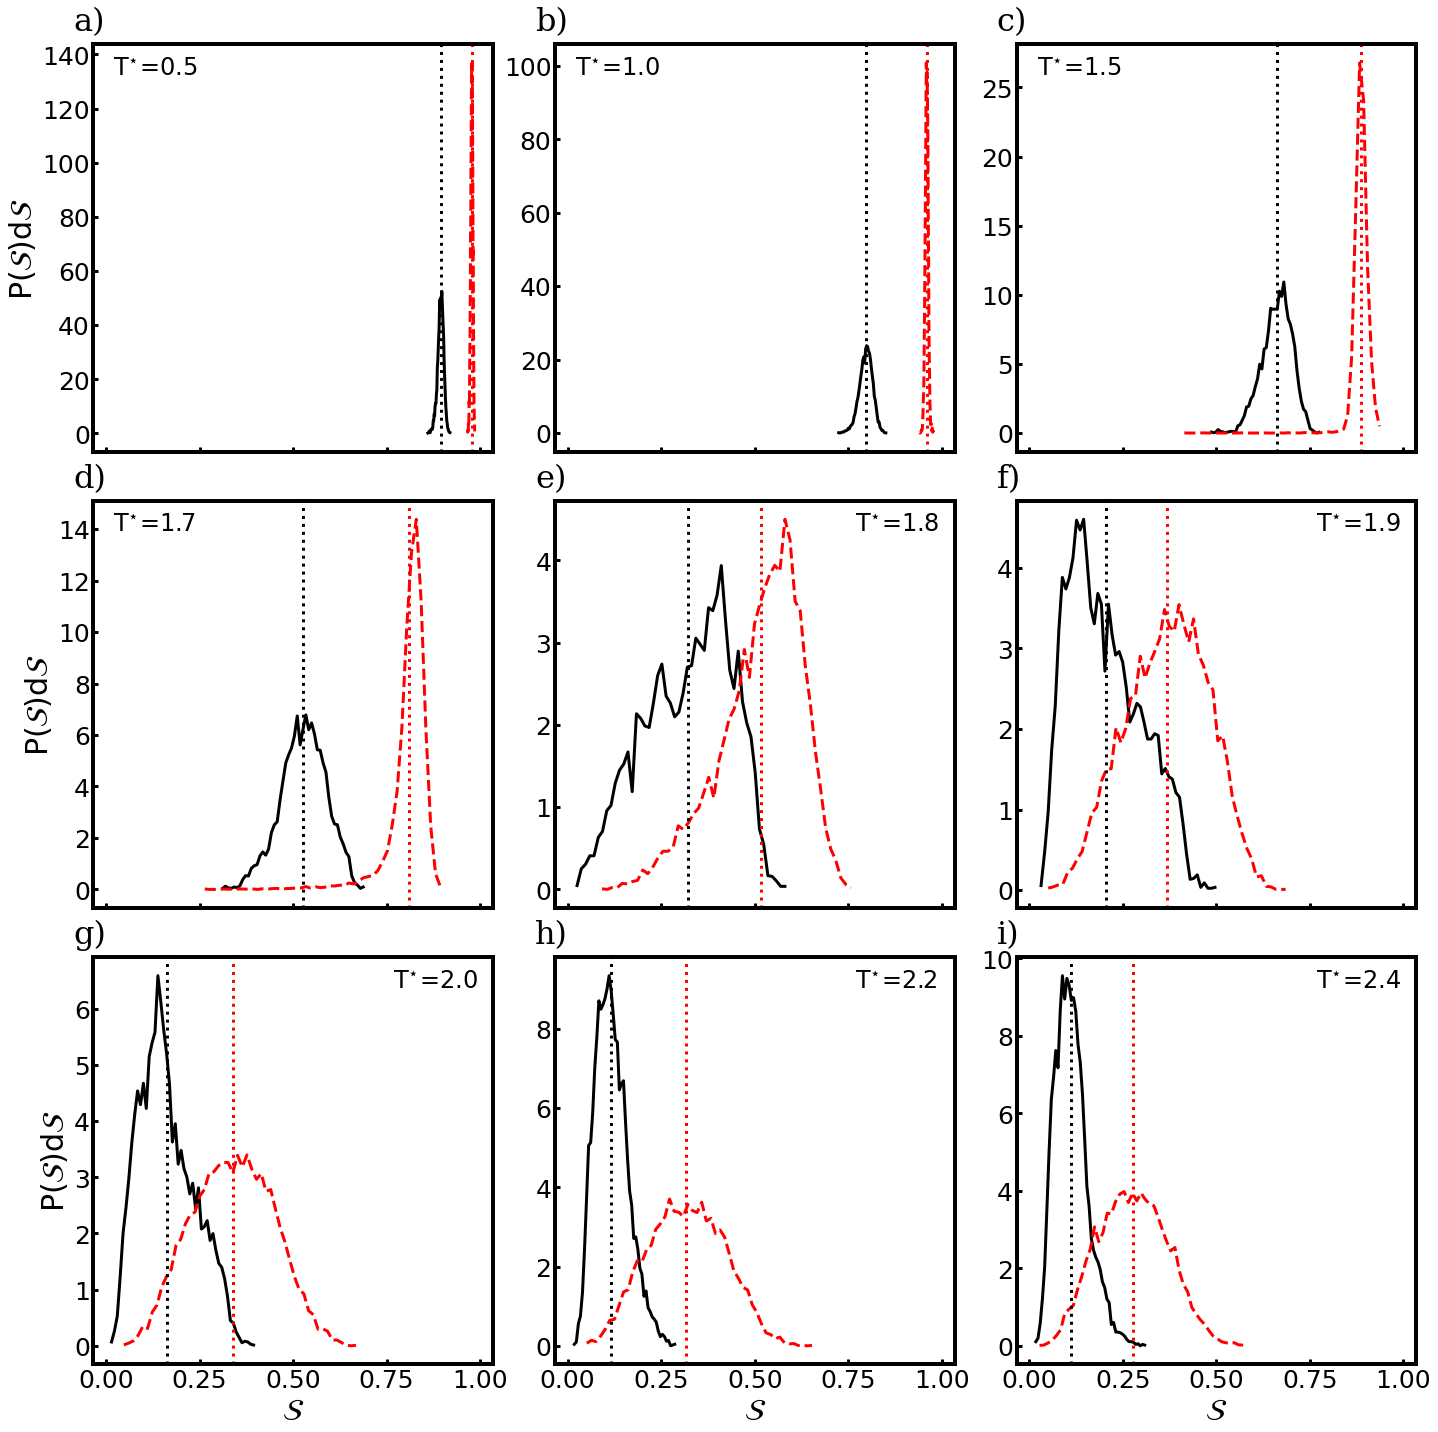

In [26]:
fig, axs = plt.subplot_mosaic([['a)', 'b)', 'c)'], ['d)', 'e)', 'f)'], ['g)', 'h)', 'i)']],
                               sharex = True, figsize = (20, 20))
T_list = [0.5, 1.0, 1.5, 1.7, 1.8, 1.9, 2.0, 2.2, 2.4]
counter = 0
for label, ax in axs.items():
    # Use ScaledTranslation to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset 20 pixels left and 7 pixels up (offset points (-20, +7)),
    # i.e. just outside the axes.
    ax.text(
        0.0, 1.0, label, transform=(
            ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
         va='bottom', fontfamily='serif', fontsize = 32)
    
    bins_md = bins_md_list[counter]
    bins_tm = bins_tm_list[counter]
    hist_md = hist_md_list[counter]
    hist_tm = hist_tm_list[counter]
    
    ax.plot(bins_md, hist_md, lw = 3, c = 'k')
    ax.plot(bins_tm, hist_tm, lw = 3, c = 'r', ls = '--')

    ax.axvline((hist_md * bins_md * (bins_md[1] - bins_md[0])).sum(), lw = 3, c = 'k', ls = ":")
    ax.axvline((hist_tm * bins_tm * (bins_tm[1] - bins_tm[0])).sum(), lw = 3, c = 'r', ls = ':')
    if counter % 3 == 0:
        ax.set_ylabel(r'P($\mathcal{S}$)d$\mathcal{S}$')
    if counter >= len(T_list) - 3:
        ax.set_xlabel(r'$\mathcal{S}$')
        
    
    T = T_list[counter]
    if T <= 1.7:
        ax.text(0.05,0.925, r'T$^{\star}$=%s' % T, transform = ax.transAxes, fontsize = 24)
    else:
        ax.text(0.75,0.925, r'T$^{\star}$=%s' % T, transform = ax.transAxes, fontsize = 24)
    counter += 1
    
    
plt.tight_layout()
plt.savefig('prob_dist_S_T.pdf', dpi = 300)
plt.show()
plt.close()

In [26]:
np.load('../T_1.5_rho_0.35/S.npy').shape

(10, 10001)

In [36]:
full_T_list = np.array([0.2, 0.5, 1.0, 1.2, 1.5, 1.7, 1.8, 1.9, 2.0, 2.2, 2.4])

0.5
../T_0.5_rho_0.35/
1


/tmp/ipykernel_2352349/437179321.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model[0].weight = torch.nn.Parameter(torch.tensor(Q.T))


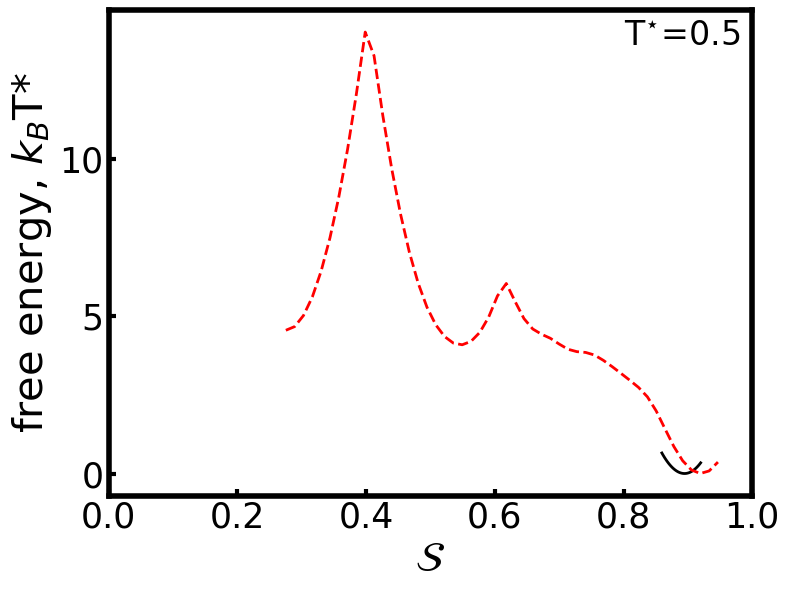

1.0
../T_1.0_rho_0.35/
2


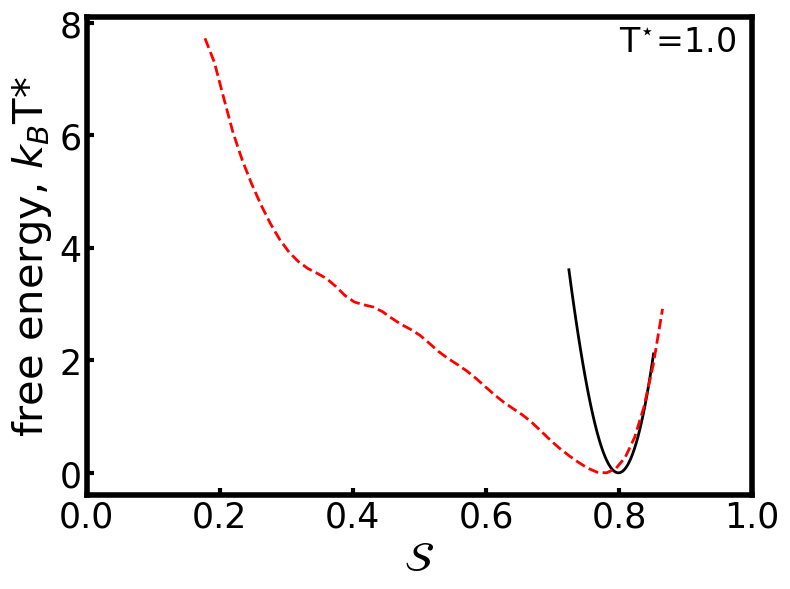

1.5
../T_1.5_rho_0.35/
4


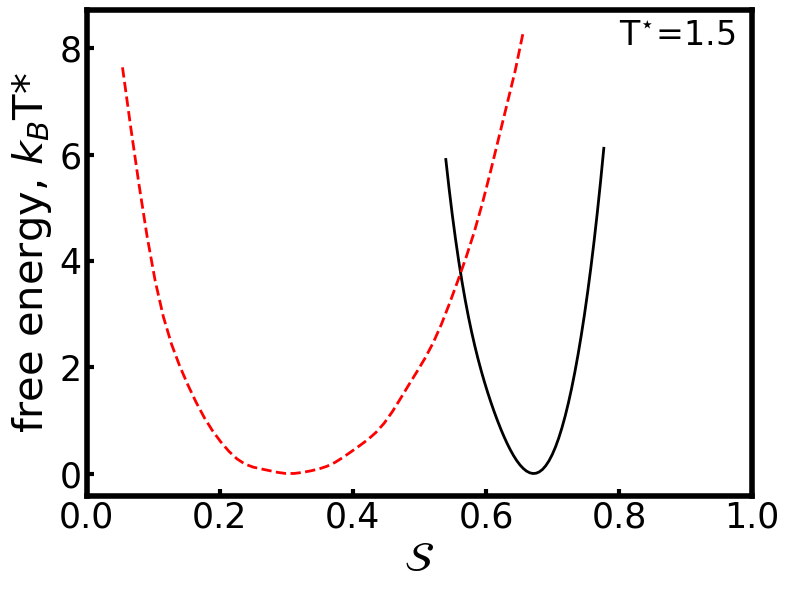

1.7
../T_1.7_rho_0.35/
5


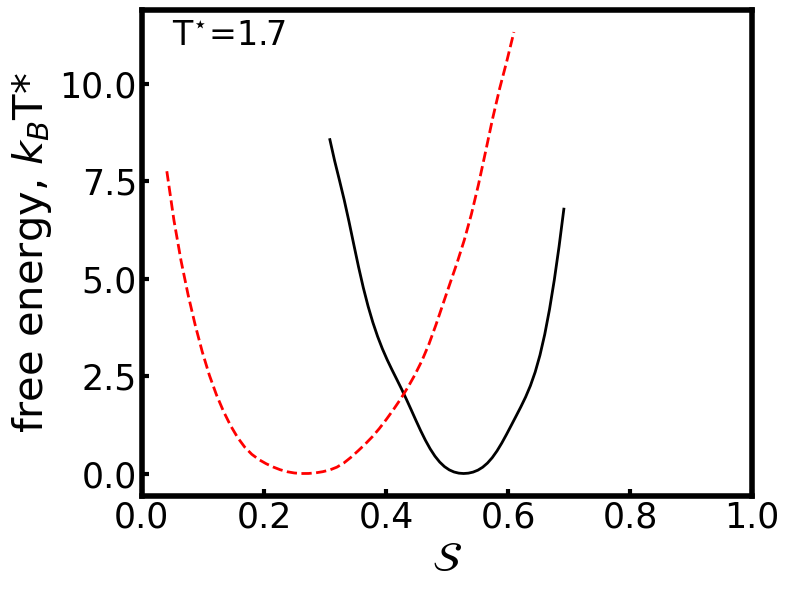

1.8
../T_1.8_rho_0.35/
6


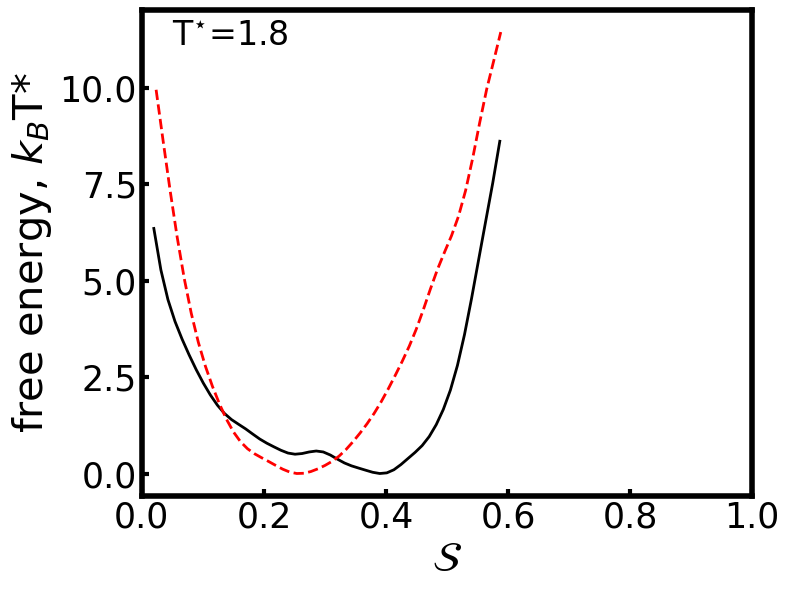

1.9
../T_1.9_rho_0.35/
7


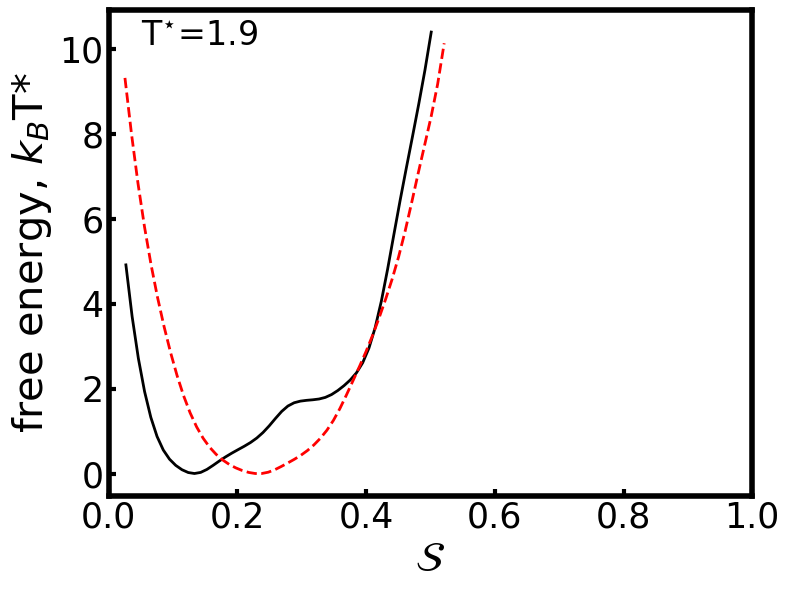

2.0
../T_2.0_rho_0.35/
8


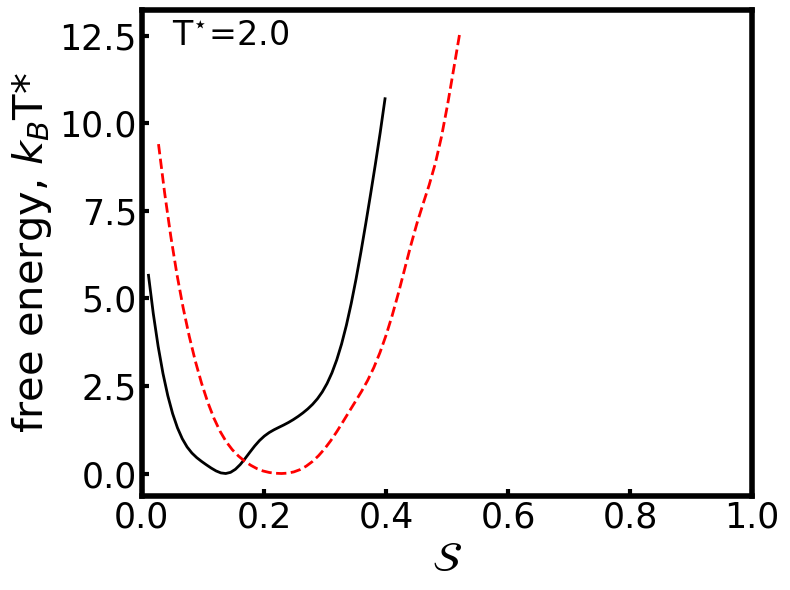

2.2
../T_2.2_rho_0.35/
9


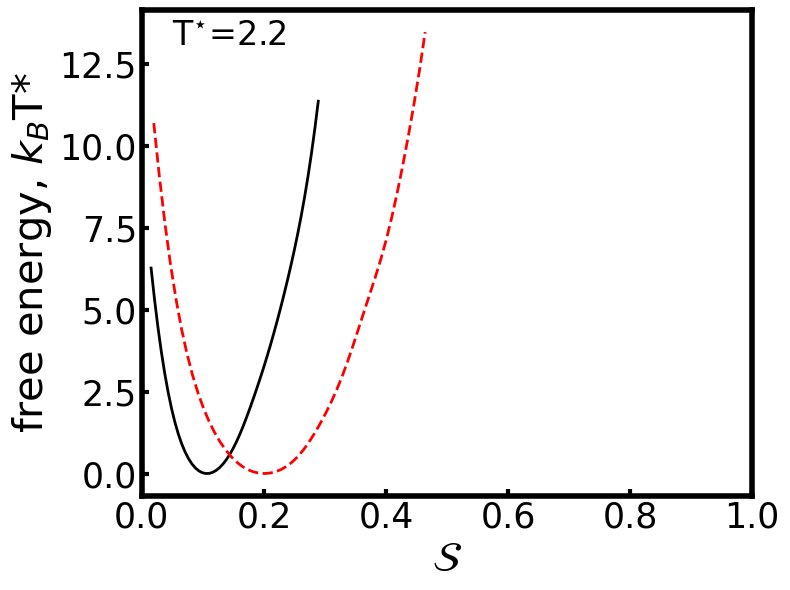

2.4
../T_2.4_rho_0.35/
10


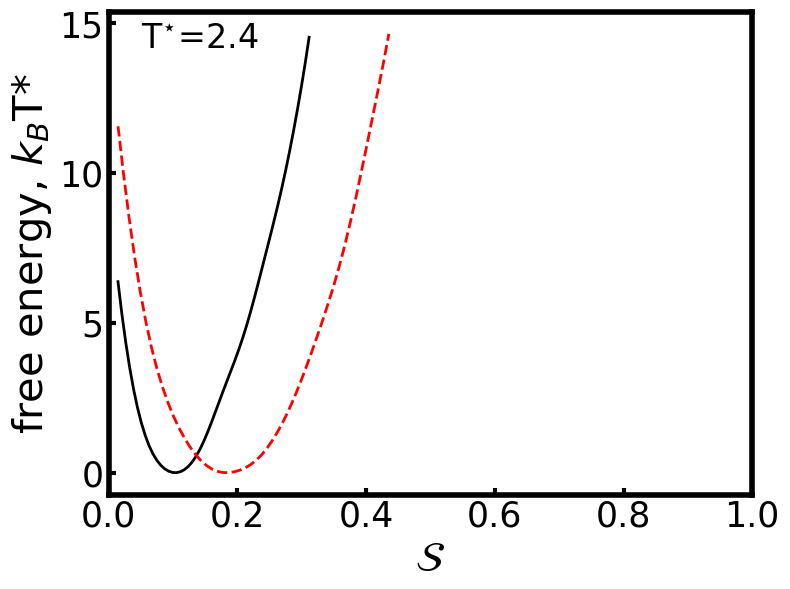

In [35]:
zbins_md_list = []
zbins_tm_list = []
fes_md_list = []
fes_tm_list = []

for nstep in [100]:
    for bs in [512]:
        for lr in [0.01]:
            tm_samples = np.load('redo/nstep_%s_bs_%s_lr_%s_samples_redo_short.npy' % (nstep, bs, lr))
            for i, T in enumerate([0.5, 1.0, 1.5, 1.7, 1.8, 1.9, 2.0, 2.2, 2.4]):

                print(T)
                directories = []
                directories.append('../T_%s_rho_0.35/' % T)
                b = 1.0 / T
                timestep = 0.15
                big_colvars = []
                colvars_list = []
                for counter, d in enumerate(directories):
                    print(d)
                    directory = d

                    sample = np.where(full_T_list == T)[0][0]; print(sample)
                
                    colvars_tm = tm_samples[sample,:][:,None]
                    colvars_md = np.load(directory + '/S.npy')[1000:,None]
                    nrg_tm = np.loadtxt(directory + '/e.txt')[:len(colvars_tm)]
                    nrg_md = np.loadtxt(directory + '/e.txt')[:len(colvars_md)]

                    length = np.min([len(colvars_tm), len(nrg_tm)])
                    weights_tm = np.ones(length)

                    length = np.min([len(colvars_md), len(nrg_md)])
                    weights_md = np.ones(length)


                IB_tm = identity_transformation(colvars_tm.shape[1])
                IB_md = identity_transformation(colvars_md.shape[1])

                data_tm = colvars_tm
                data_md = colvars_md
                torch_data_tm = torch.Tensor(data_tm)
                torch_data_md = torch.Tensor(data_md)
                torch_data_tm.requires_grad = True
                torch_data_md.requires_grad = True

                z_mean_tm, grad_list_tm = jacobian.torch_jacobian_1d(torch_data_tm, IB_tm.forward(torch_data_tm), all_inputs = True)
                z_mean_md, grad_list_md = jacobian.torch_jacobian_1d(torch_data_md, IB_md.forward(torch_data_md), all_inputs = True)

                path = '/media/ebeyerle/seagate/frenkel/ellipsoid/GB/nvt/GB_3_5_2_1/anneal/T_%s_rho_0.35/' % T
                PATH = path

                #x = data[:,0]

                nreps = 1
                seed = 0
                bandwidth = "1e-1"
                lr = 0.000100
                nn = 16
                gamma = 0.0
                z1_bar_list = []
                z2_bar_list = []
                tensor_weights_tm = torch.Tensor(weights_tm)
                tensor_weights_md = torch.Tensor(weights_md)
                output_thermo = True
                aux_loss_tm, G11_tm, U11_tm, S11_tm = constraints.variational(torch_data_tm, 
                                                                             z_mean_tm, nrg_tm, 
                                                                             bins = 50, bandwidth = 0.02, 
                                                                             output_thermo = output_thermo,
                                                                             b = b, weights = tensor_weights_tm)
                z_tm = z_mean_tm.detach().numpy()

                aux_loss_md, G11_md, U11_md, S11_md = constraints.variational(torch_data_md, 
                                                                             z_mean_md, nrg_md, 
                                                                             bins = 50, bandwidth = 0.02, 
                                                                             output_thermo = output_thermo,
                                                                             b = b, weights = tensor_weights_md)
                z_md = z_mean_md.detach().numpy()


                fig, ax = plt.subplots()
                zbins_tm = np.linspace(z_tm[:,0].min() - 1e-9, z_tm[:,0].max() + 1e-9, len(U11_tm))
                zbins_md = np.linspace(z_md[:,0].min() - 1e-9, z_md[:,0].max() + 1e-9, len(U11_md))
                zbins_md_list.append(zbins_md)
                zbins_tm_list.append(zbins_tm)
                fes_md_list.append(G11_md.detach().numpy() / b)
                fes_tm_list.append(G11_tm.detach().numpy() / b)
                ax.plot(zbins_md, G11_md.detach().numpy() / b, lw = 2, c = 'k', label = r'$\Delta$G_{\text{MD}}($\mathcal{S}$)')
                ax.plot(zbins_tm, G11_tm.detach().numpy() / b, lw = 2, c = 'r', ls = '--', label = r'$\Delta$G_{\text{TM}}($\mathcal{S}$)')    
                #ax.plot(zbins, U11.detach().numpy() / b, lw = 2, c = 'r', label = r'$\Delta$U($\mathcal{S}$)')
                #ax.plot(zbins, S11.detach().numpy() / b, lw = 2, c = 'b', label = r'$-T\Delta$S($\mathcal{S}$)')
                #plt.axvline(z[:,0].min() + 0.5 * z[:,0].std(), lw =2, c = 'grey', ls = '--')
                #plt.axvline(z[:,0].max() - 0.5 * z[:,0].std(), lw =2, c = 'grey', ls = '--')  
                #if T == 1.2:
                #    ax.legend(fontsize = 20, loc = 'upper right', framealpha = 0.25)
                ax.set_xlabel(r'$\mathcal{S}$')
                ax.set_ylabel(r'free energy, $k_B$T*')
                #plt.ylim((-1,5))
                #plt.ylim((-50, 50))
                plt.xlim((0, 1))
                if T >= 1.7:
                    plt.text(0.05,0.925, r'T$^{\star}$=%s' % T, transform = ax.transAxes, fontsize = 24)
                else:
                    plt.text(0.8,0.925, r'T$^{\star}$=%s' % T, transform = ax.transAxes, fontsize = 24)
                plt.tight_layout()
                #plt.savefig('fes_S_T%s.pdf' % T, dpi = 300)
                plt.show()
                plt.close()

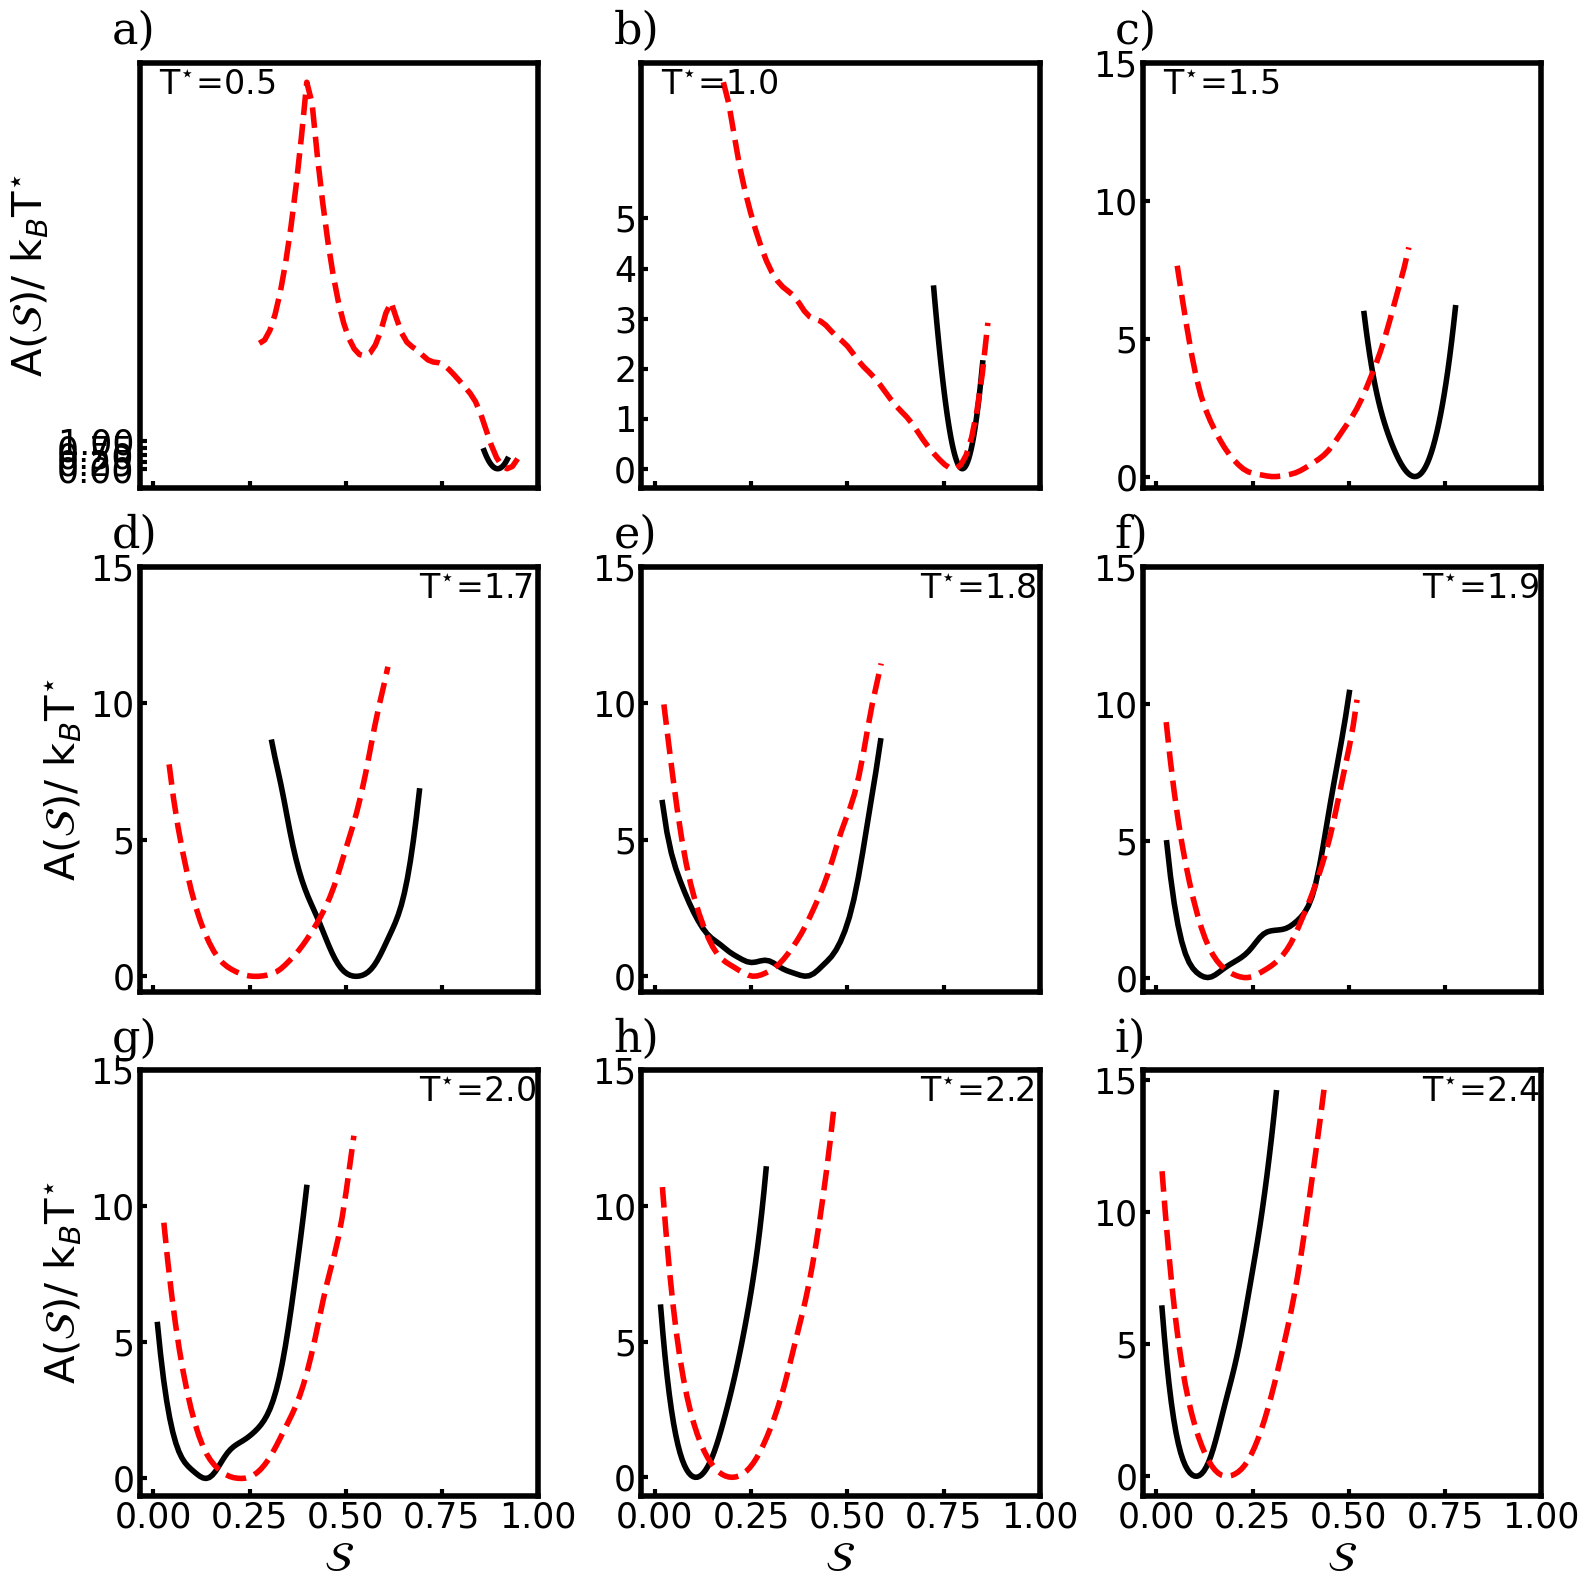

In [37]:
fig, axs = plt.subplot_mosaic([['a)', 'b)', 'c)'], ['d)', 'e)', 'f)'], ['g)', 'h)', 'i)']],
                               sharex = True, figsize = (16, 16))
T_list = [0.5, 1.0, 1.5, 1.7, 1.8, 1.9, 2.0, 2.2, 2.4]
counter = 0
for label, ax in axs.items():
    # Use ScaledTranslation to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset 20 pixels left and 7 pixels up (offset points (-20, +7)),
    # i.e. just outside the axes.
    ax.text(
        0.0, 1.0, label, transform=(
            ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
         va='bottom', fontfamily='serif', fontsize = 32)

    sample = np.where(full_T_list == T_list[counter])[0][0]
    
    bins_md = zbins_md_list[counter]
    bins_tm = zbins_tm_list[counter]
    hist_md = fes_md_list[counter]
    hist_tm = fes_tm_list[counter]
    
    ax.plot(bins_md, hist_md, lw = 4, c = 'k')
    ax.plot(bins_tm, hist_tm, lw = 4, c = 'r', ls = '--')

    #ax.axvline((hist_md * bins_md * (bins_md[1] - bins_md[0])).sum(), lw = 3, c = 'k', ls = ":")
    #ax.axvline((hist_tm * bins_tm * (bins_tm[1] - bins_tm[0])).sum(), lw = 3, c = 'r', ls = ':')
    if counter % 3 == 0:
        ax.set_ylabel(r'A($\mathcal{S}$)/ k$_B$T$^{\star}$')
    if counter >= len(T_list) - 3:
        ax.set_xlabel(r'$\mathcal{S}$')
        
    
    T = T_list[counter]
    #ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    #if T == 0.5:
    #    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    #elif T == 1.0:
    #    ax.set_yticks([0, 1, 2, 3, 4, 5])
    #else:
    ax.set_yticks([0, 5, 10, 15])
    if T <= 1.5:
        ax.text(0.05,0.925, r'T$^{\star}$=%s' % T, transform = ax.transAxes, fontsize = 24)
    else:
        ax.text(0.7,0.925, r'T$^{\star}$=%s' % T, transform = ax.transAxes, fontsize = 24)
    counter += 1
    
    
plt.tight_layout()
plt.savefig('fes_S_T.pdf', dpi = 300)
plt.show()
plt.close()

In [20]:
tm_samples.shape

(11, 10000)

In [21]:
T_list

[1.0, 1.7, 1.8, 2.0]

In [18]:
zbins_md_list = []
zbins_tm_list = []
fes_md_list = []
fes_tm_list = []

for nstep in [100]:
    for bs in [512]:
        for lr in [0.01]:
            tm_samples = np.load('redo/nstep_%s_bs_%s_lr_%s_samples_redo_short.npy' % (nstep, bs, lr))
            for i, T in enumerate([1.0, 1.7, 1.8, 2.0]):

                print(T)
                directories = []
                directories.append('../T_%s_rho_0.35/' % T)
                b = 1.0 / T
                timestep = 0.15
                big_colvars = []
                colvars_list = []
                for counter, d in enumerate(directories):
                    print(d)
                    directory = d

                    colvars_tm = tm_samples[i,:][:,None]
                    colvars_md = np.load(directory + '/S.npy')[1000:,None]
                    nrg_tm = np.loadtxt(directory + '/e.txt')[:len(colvars_tm)]
                    nrg_md = np.loadtxt(directory + '/e.txt')[:len(colvars_md)]

                    length = np.min([len(colvars_tm), len(nrg_tm)])
                    weights_tm = np.ones(length)

                    length = np.min([len(colvars_md), len(nrg_md)])
                    weights_md = np.ones(length)


                IB_tm = identity_transformation(colvars_tm.shape[1])
                IB_md = identity_transformation(colvars_md.shape[1])

                data_tm = colvars_tm
                data_md = colvars_md
                torch_data_tm = torch.Tensor(data_tm)
                torch_data_md = torch.Tensor(data_md)
                torch_data_tm.requires_grad = True
                torch_data_md.requires_grad = True

                z_mean_tm, grad_list_tm = jacobian.torch_jacobian_1d(torch_data_tm, IB_tm.forward(torch_data_tm), all_inputs = True)
                z_mean_md, grad_list_md = jacobian.torch_jacobian_1d(torch_data_md, IB_md.forward(torch_data_md), all_inputs = True)

                path = '/media/ebeyerle/seagate/frenkel/ellipsoid/GB/nvt/GB_3_5_2_1/anneal/T_%s_rho_0.35/' % T
                PATH = path

                #x = data[:,0]

                nreps = 1
                seed = 0
                bandwidth = "1e-1"
                lr = 0.000100
                nn = 16
                gamma = 0.0
                z1_bar_list = []
                z2_bar_list = []
                tensor_weights_tm = torch.Tensor(weights_tm)
                tensor_weights_md = torch.Tensor(weights_md)
                output_thermo = True
                aux_loss_tm, G11_tm, U11_tm, S11_tm = constraints.variational(torch_data_tm, 
                                                                             z_mean_tm, nrg_tm, 
                                                                             bins = 50, bandwidth = 0.02, 
                                                                             output_thermo = output_thermo,
                                                                             b = b, weights = tensor_weights_tm)
                z_tm = z_mean_tm.detach().numpy()

                aux_loss_md, G11_md, U11_md, S11_md = constraints.variational(torch_data_md, 
                                                                             z_mean_md, nrg_md, 
                                                                             bins = 50, bandwidth = 0.02, 
                                                                             output_thermo = output_thermo,
                                                                             b = b, weights = tensor_weights_md)
                z_md = z_mean_md.detach().numpy()


                zbins_tm = np.linspace(z_tm[:,0].min() - 1e-9, z_tm[:,0].max() + 1e-9, len(U11_tm))
                zbins_md = np.linspace(z_md[:,0].min() - 1e-9, z_md[:,0].max() + 1e-9, len(U11_md))
                zbins_md_list.append(zbins_md)
                zbins_tm_list.append(zbins_tm)
                fes_md_list.append(G11_md.detach().numpy() / b)
                fes_tm_list.append(G11_tm.detach().numpy() / b)

1.0
../T_1.0_rho_0.35/
1.7
../T_1.7_rho_0.35/
1.8
../T_1.8_rho_0.35/
2.0
../T_2.0_rho_0.35/


/tmp/ipykernel_2352349/437179321.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model[0].weight = torch.nn.Parameter(torch.tensor(Q.T))


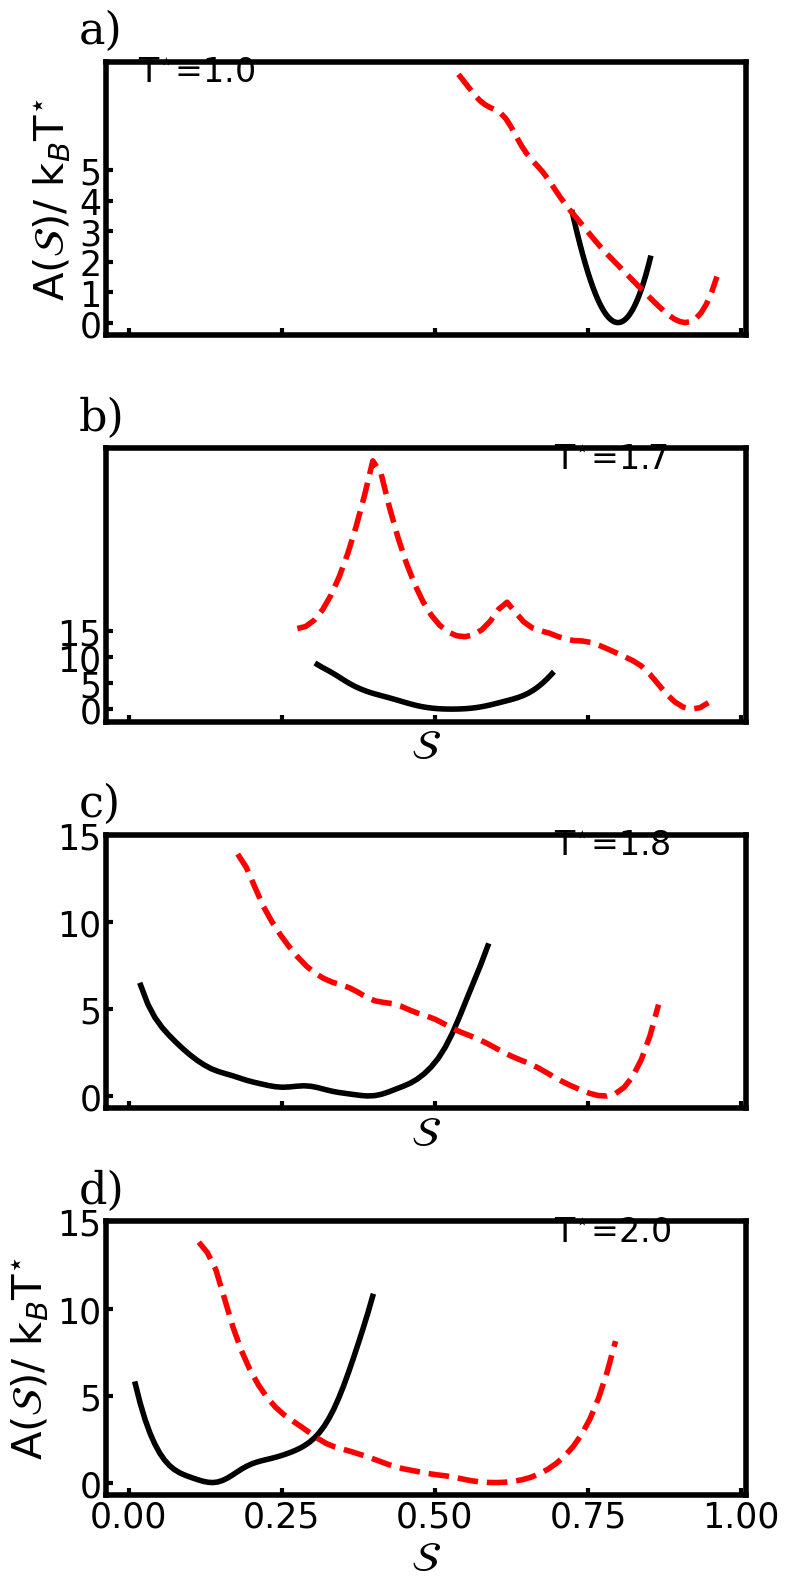

In [19]:
fig, axs = plt.subplot_mosaic([['a)'], ['b)'], ['c)'], ['d)']],
                               sharex = True, figsize = (8, 16))
T_list = [1.0, 1.7, 1.8, 2.0]
counter = 0
for label, ax in axs.items():
    # Use ScaledTranslation to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset 20 pixels left and 7 pixels up (offset points (-20, +7)),
    # i.e. just outside the axes.
    ax.text(
        0.0, 1.0, label, transform=(
            ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
         va='bottom', fontfamily='serif', fontsize = 32)
    
    bins_md = zbins_md_list[counter]
    bins_tm = zbins_tm_list[counter]
    hist_md = fes_md_list[counter]
    hist_tm = fes_tm_list[counter]
    
    ax.plot(bins_md, hist_md, lw = 4, c = 'k')
    ax.plot(bins_tm, hist_tm, lw = 4, c = 'r', ls = '--')

    #ax.axvline((hist_md * bins_md * (bins_md[1] - bins_md[0])).sum(), lw = 3, c = 'k', ls = ":")
    #ax.axvline((hist_tm * bins_tm * (bins_tm[1] - bins_tm[0])).sum(), lw = 3, c = 'r', ls = ':')
    if counter % 3 == 0:
        ax.set_ylabel(r'A($\mathcal{S}$)/ k$_B$T$^{\star}$')
    if counter >= len(T_list) - 3:
        ax.set_xlabel(r'$\mathcal{S}$')
        
    
    T = T_list[counter]
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    if T == 0.5:
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    elif T == 1.0:
        ax.set_yticks([0, 1, 2, 3, 4, 5])
    else:
        ax.set_yticks([0, 5, 10, 15])
    if T <= 1.5:
        ax.text(0.05,0.925, r'T$^{\star}$=%s' % T, transform = ax.transAxes, fontsize = 24)
    else:
        ax.text(0.7,0.925, r'T$^{\star}$=%s' % T, transform = ax.transAxes, fontsize = 24)
    counter += 1
    
    
plt.tight_layout()
plt.savefig('fes_S_T_four_panels.pdf', dpi = 300)
plt.show()
plt.close()

In [43]:
tmp = np.loadtxt('../T_1.0_rho_0.4/biased/COLVAR', max_rows=69823)

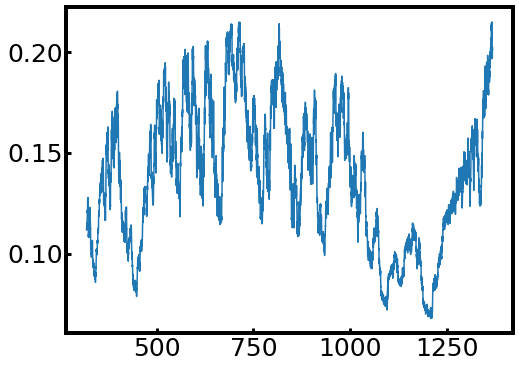

In [44]:
plt.plot(tmp[:,0], tmp[:,1])

In [45]:
len(tmp)

69823

(array([ 3129.,  6585.,  8259.,  8924., 10553.,  9751.,  8786.,  7060.,
         4599.,  2177.]),
 array([0.067779 , 0.0825049, 0.0972308, 0.1119567, 0.1266826, 0.1414085,
        0.1561344, 0.1708603, 0.1855862, 0.2003121, 0.215038 ]),
 <BarContainer object of 10 artists>)

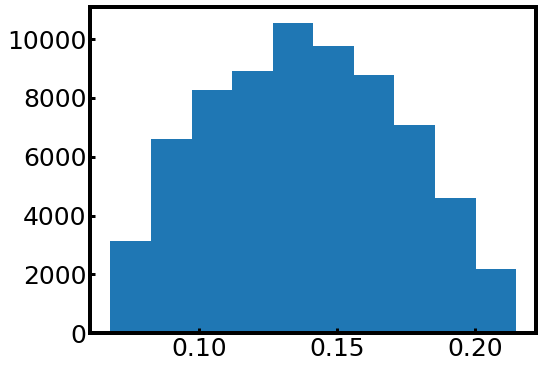

In [46]:
plt.hist(tmp[:,1])

In [12]:
directories = []
for i in [0.2, 0.25, 0.3, 0.35, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    directories.append('../T_1.0_rho_%s/' % i)
    #directories.append('../T_1.77_rho_0.35/2/')
    #directories.append('../T_1.77_rho_0.35/3/')

../T_1.0_rho_0.2/
23855


/tmp/ipykernel_2932106/437179321.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model[0].weight = torch.nn.Parameter(torch.tensor(Q.T))
/tmp/ipykernel_2932106/1105444950.py:63: RuntimeWarning: divide by zero encountered in log
  fes  = -np.log(histo).T


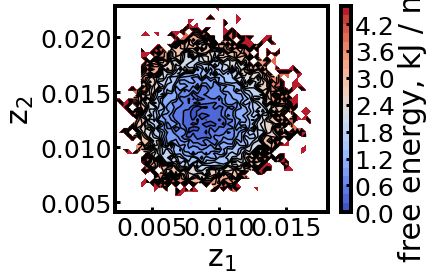

/tmp/ipykernel_2932106/1105444950.py:85: RuntimeWarning: invalid value encountered in true_divide
  RC=np.divide(hist_RC[0],hist[0])


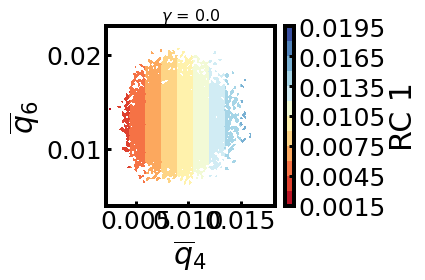

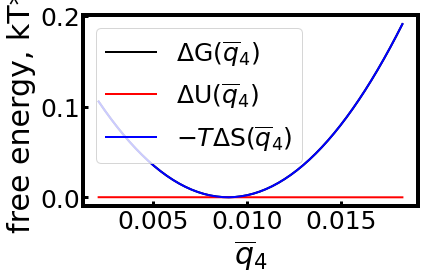

/tmp/ipykernel_2932106/1105444950.py:121: RuntimeWarning: invalid value encountered in true_divide
  RC=np.divide(hist_RC[0],hist[0])


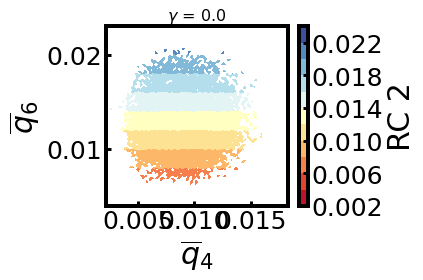

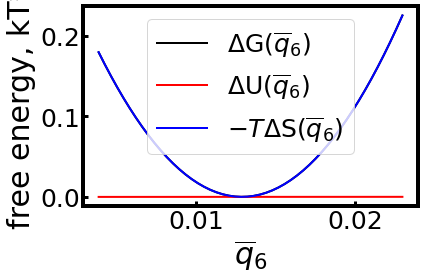

../T_1.0_rho_0.25/
19890


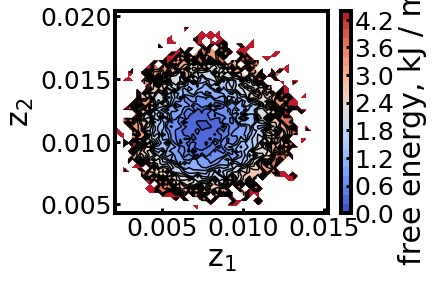

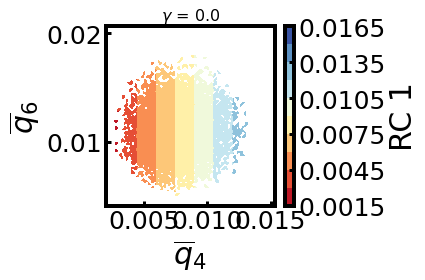

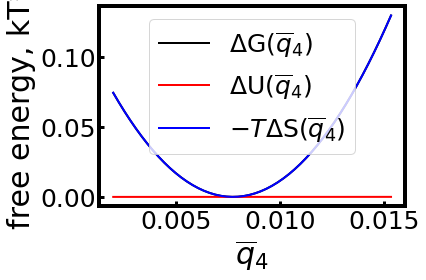

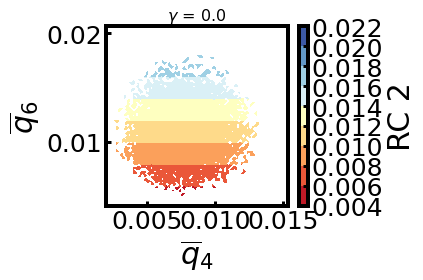

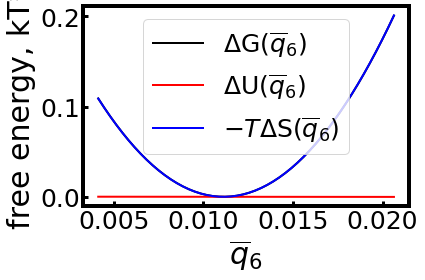

../T_1.0_rho_0.3/
16438


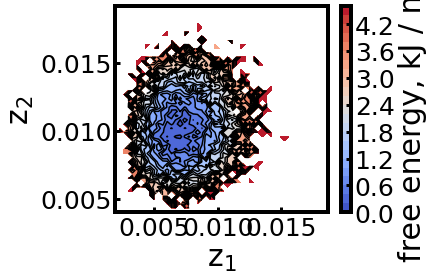

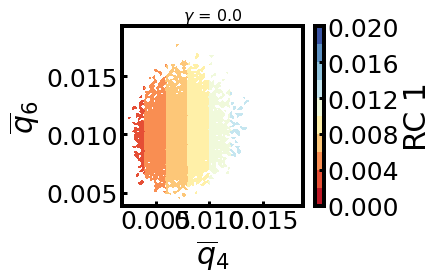

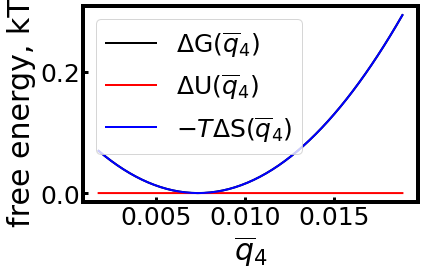

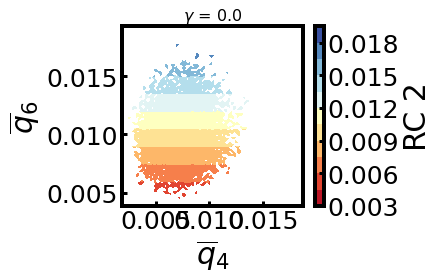

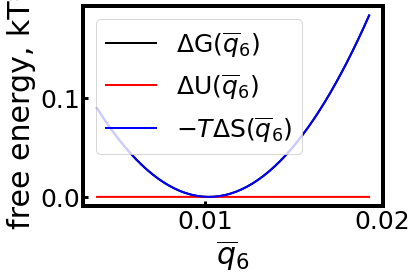

../T_1.0_rho_0.35/
39415


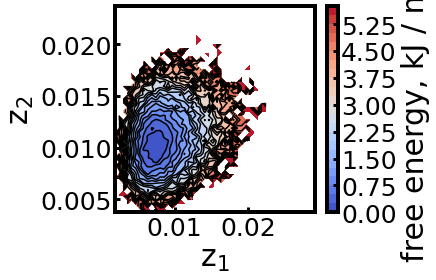

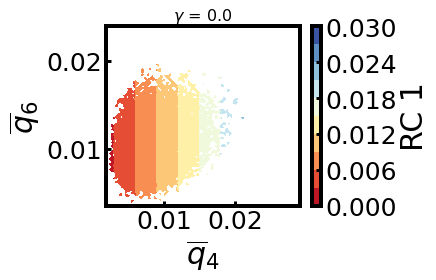

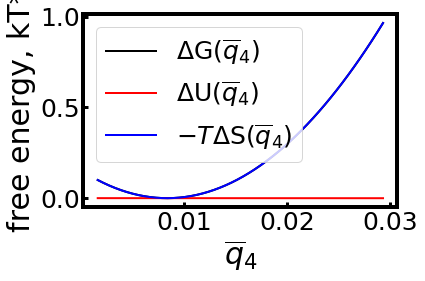

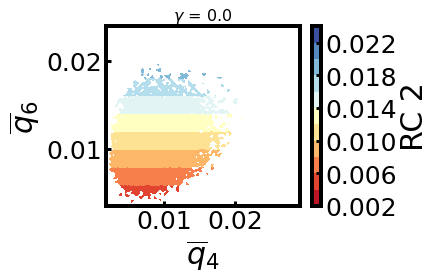

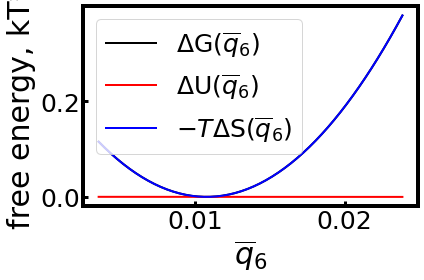

../T_1.0_rho_0.4/
12295


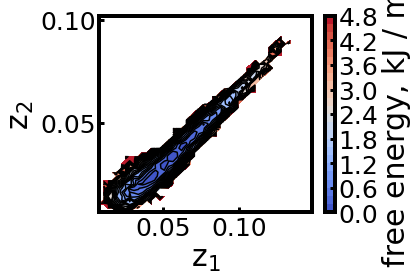

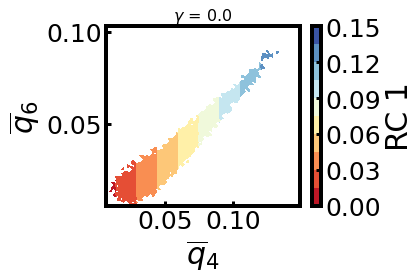

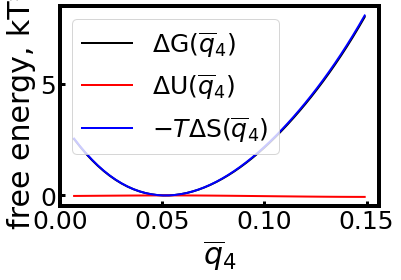

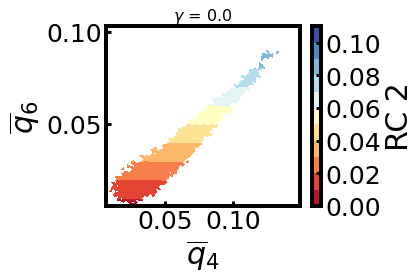

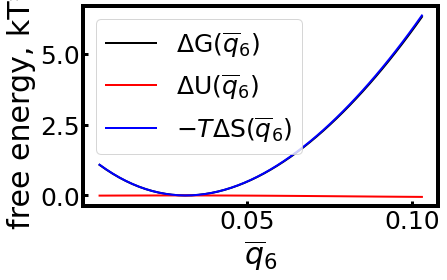

../T_1.0_rho_0.41/
1790


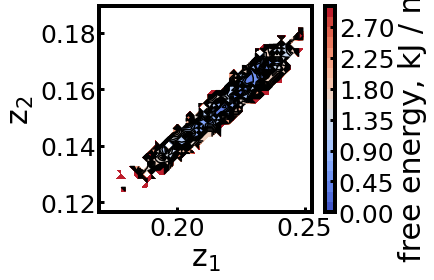

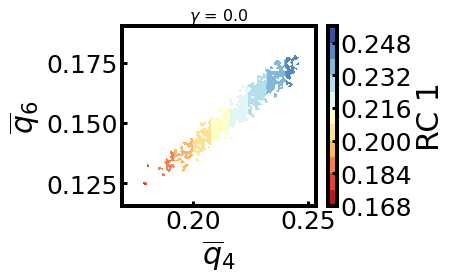

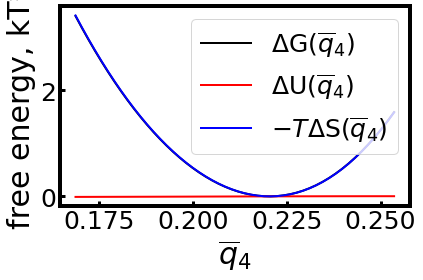

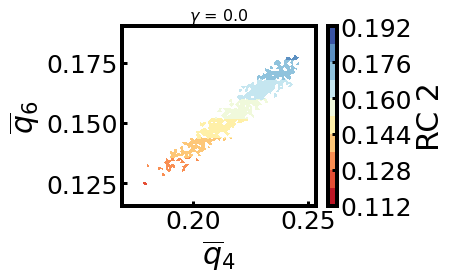

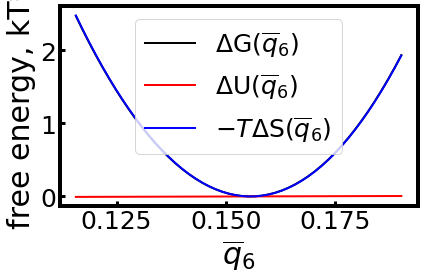

../T_1.0_rho_0.42/
1714


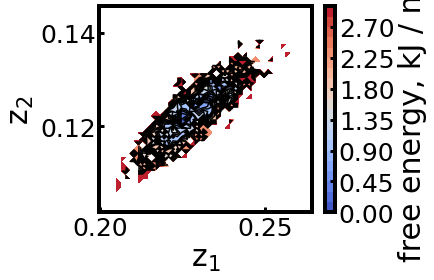

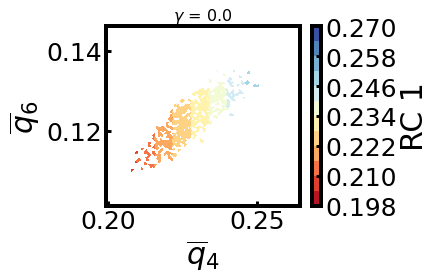

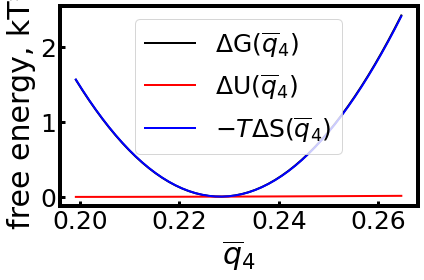

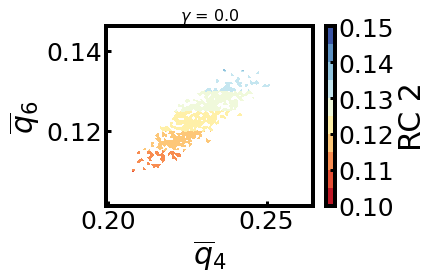

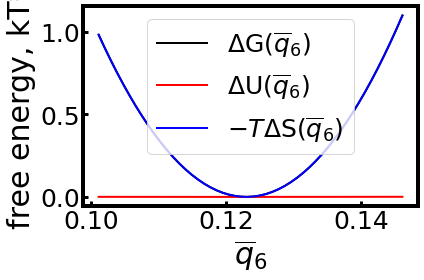

../T_1.0_rho_0.43/
1681


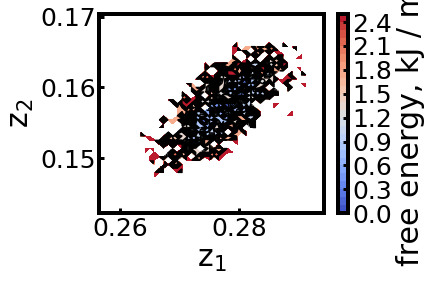

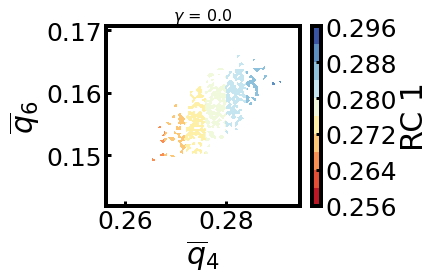

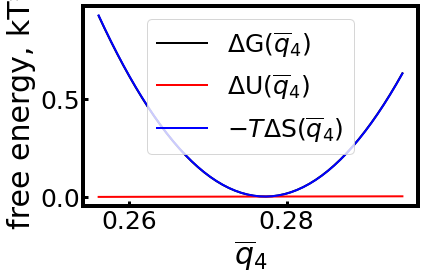

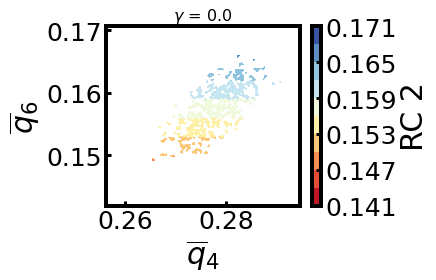

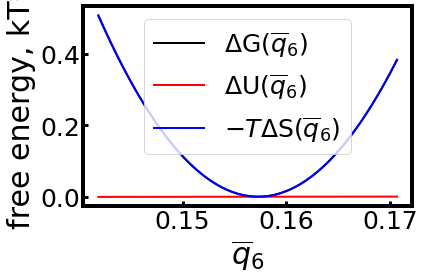

../T_1.0_rho_0.44/
1635


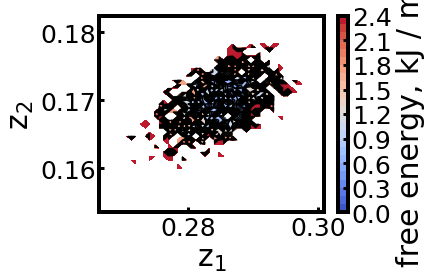

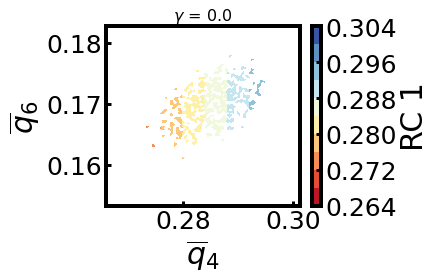

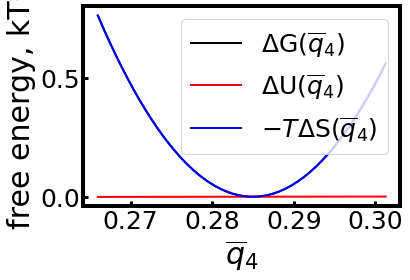

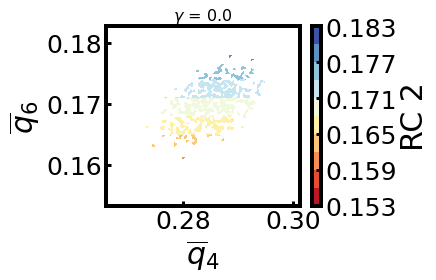

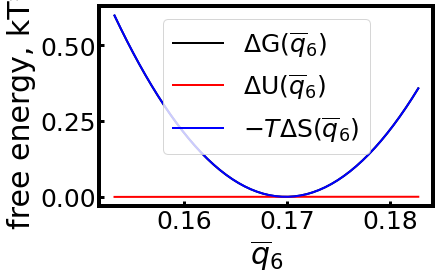

../T_1.0_rho_0.45/
10617


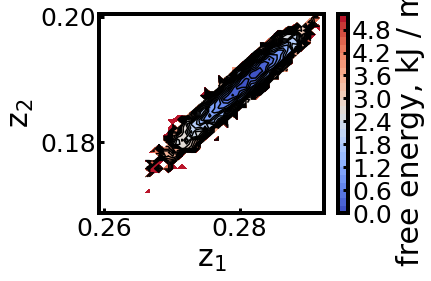

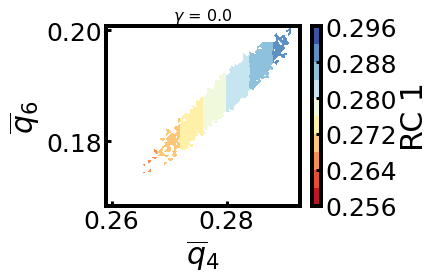

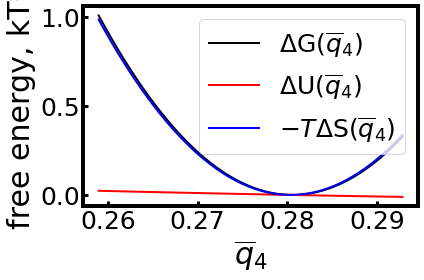

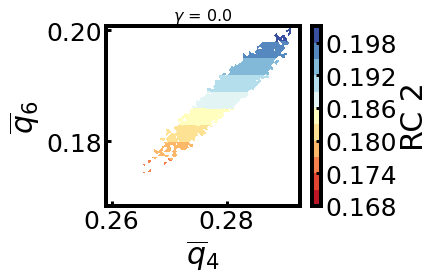

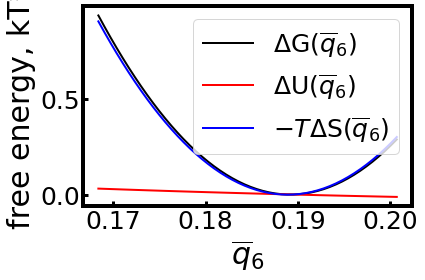

../T_1.0_rho_0.5/
26547


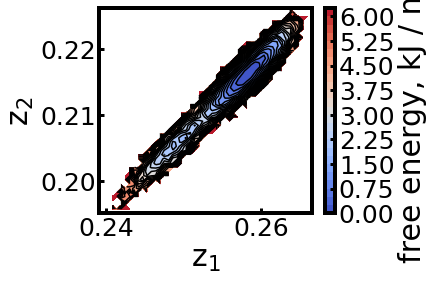

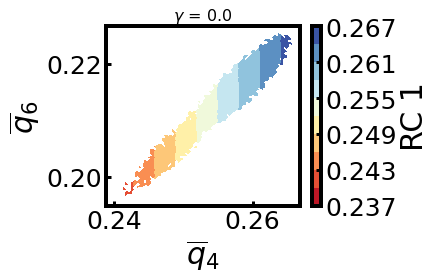

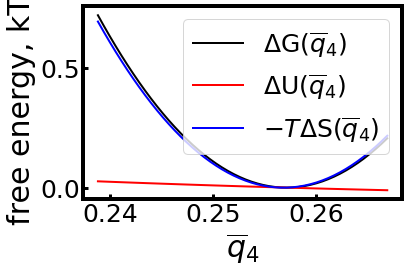

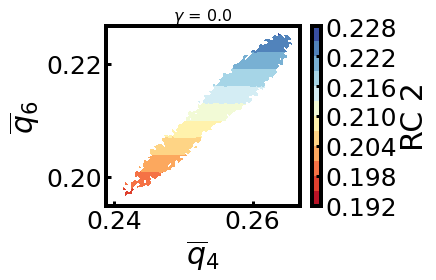

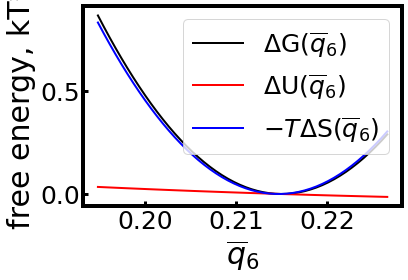

../T_1.0_rho_0.55/
23070


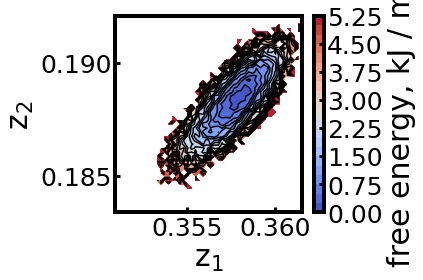

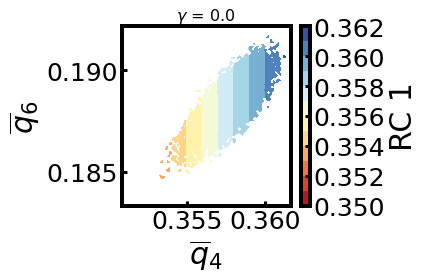

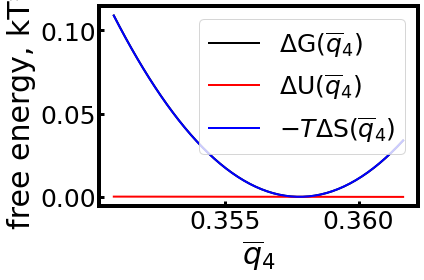

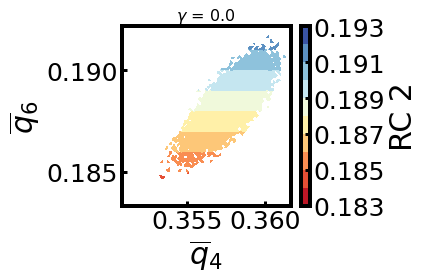

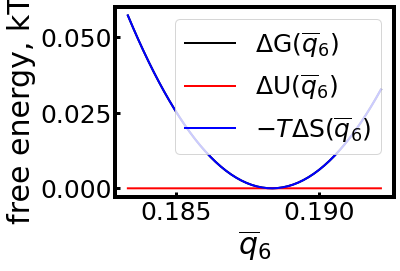

../T_1.0_rho_0.6/
7791


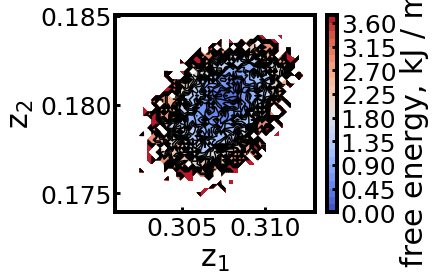

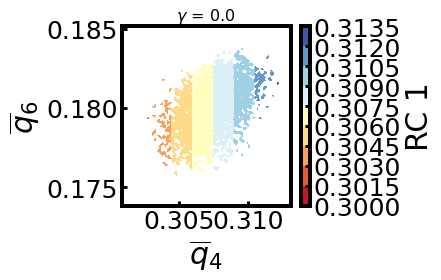

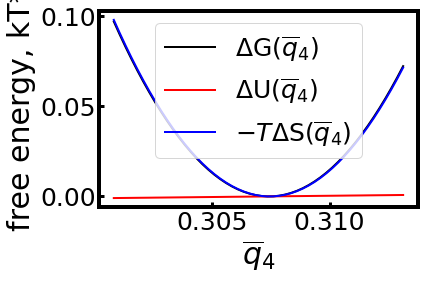

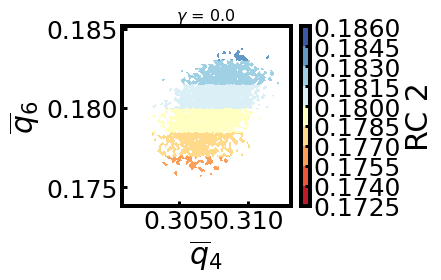

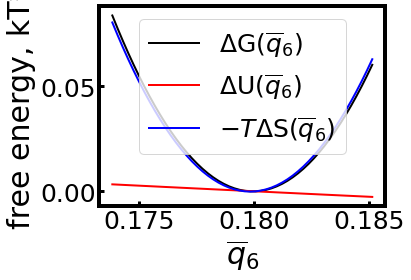

../T_1.0_rho_0.65/
7286


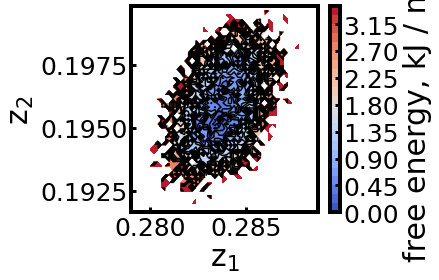

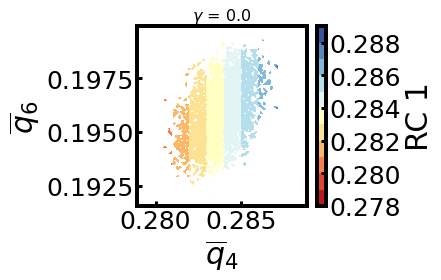

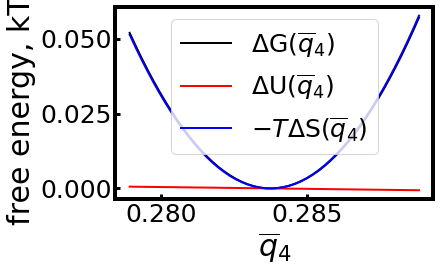

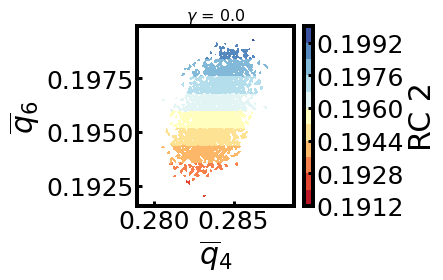

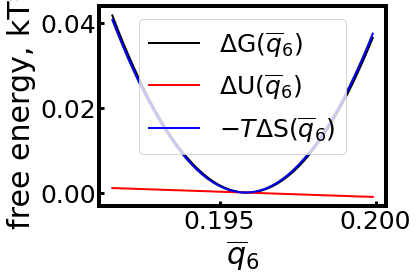

../T_1.0_rho_0.7/
6761


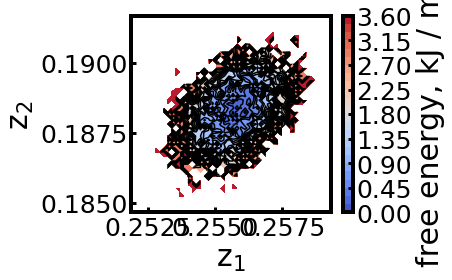

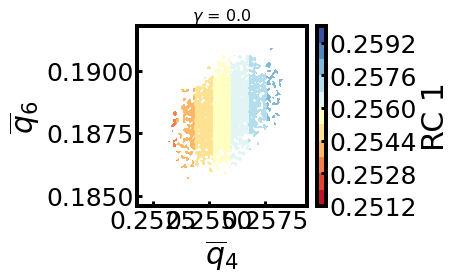

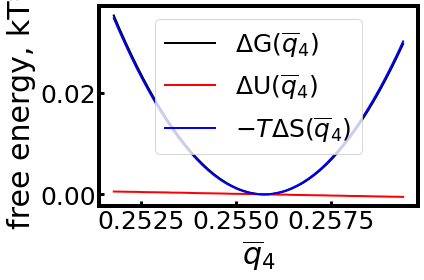

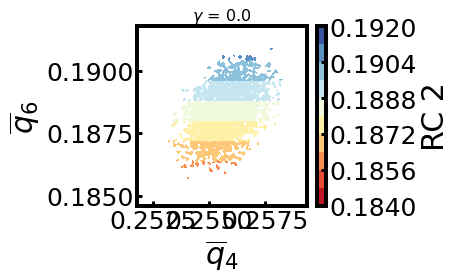

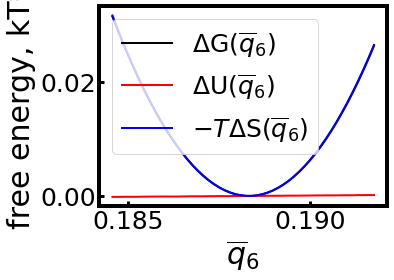

../T_1.0_rho_0.75/
6371


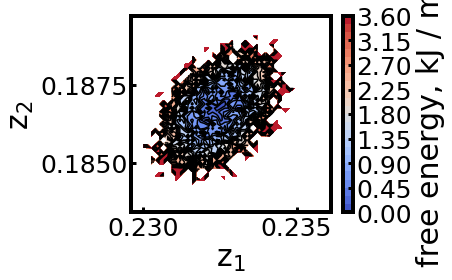

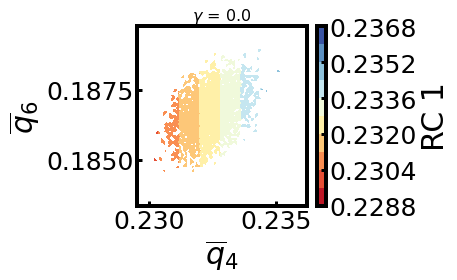

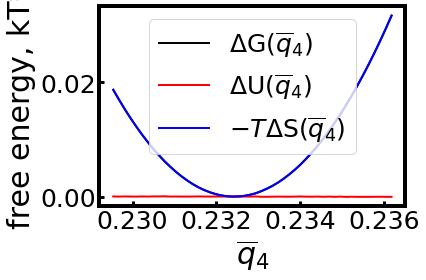

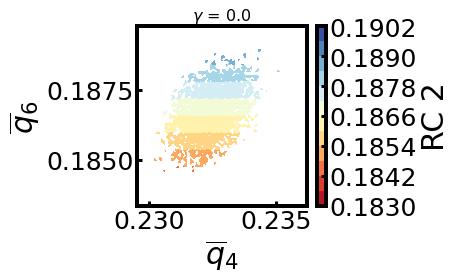

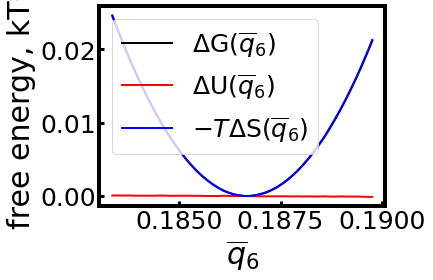

In [23]:
timestep = 0.15
big_colvars = []
colvars_list = []
rho_list = [0.2, 0.25, 0.3, 0.35, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
q4_list = []
for counter, d in enumerate(directories):
    print(d)
    directory = d

    if rho_list[counter] in [0.41, 0.42, 0.43, 0.44, 0.6, 0.65, 0.7, 0.75]:
        colvars = np.load(directory + '/steinhardt.npy')[500:][::5]
        nrg = np.loadtxt(directory + '/e.txt')[500:][::5]
    else:
        colvars = np.load(directory + '/new_C_perp_colvar.npy')[500:][::5]
        nrg = np.loadtxt(directory + '/e.txt')[500:][::5]
    weights = np.ones(len(colvars))

    length = np.min([len(nrg), len(weights), len(colvars)])
    print(length)
    

    big_colvars = colvars[:length]
    big_weights = weights[:length]
    big_nrg = nrg[:length]
    
    IB = identity_transformation(colvars.shape[1])
    
    data = np.column_stack([big_colvars[:,-2], big_colvars[:,-1]])
    IB = identity_transformation(data.shape[1])
    torch_data = torch.Tensor(data)
    torch_data.requires_grad = True
    
    z_mean, grad_list = jacobian.torch_jacobian_1d(torch_data, IB.forward(torch_data), all_inputs = True)
    
    x = data[:,0]
    y = data[:,1]
    
    nreps = 1
    seed = 0
    bandwidth = "1e-1"
    lr = 0.000100
    nn = 16
    gamma = 0.0
    z1_bar_list = []
    z2_bar_list = []
    tensor_weights = torch.Tensor(big_weights)
    output_thermo = True
    aux_loss, G11, U11, S11, G22, U22, S22 = constraints.variational(torch_data, 
                                                                             z_mean, big_nrg, 
                                                                             bins = 50, bandwidth = 0.02, 
                                                                             output_thermo = output_thermo,
                                                                             b = b, weights = tensor_weights)
    z = z_mean.detach().numpy()


    q4_list.append(z[:,0].mean())

    hist = np.histogram2d(z[:,0],z[:,1],bins = 50, weights = big_weights)
    histo = hist[0] / hist[0].sum()
    xbins = (hist[1][:-1] + hist[1][1:]) / 2
    ybins = (hist[2][:-1] + hist[2][1:]) / 2

    fes  = -np.log(histo).T
    fes = fes - fes.min()

    kT = 1.
    xx, yy = np.meshgrid(xbins, ybins)
    im = plt.contourf(xx, yy, kT * fes, levels = 25, cmap = 'coolwarm')
    plt.contour(xx, yy, kT * fes, levels = 25, colors = 'k')
    cbar = plt.colorbar(im)
    cbar.set_label('free energy, kJ / mol')
    plt.xlabel(r"z$_1$")
    plt.ylabel(r"z$_2$")
    plt.tight_layout()
    #plt.savefig(prefix + '_latent_space_fes.pdf', dpi = 300)
    plt.show()
    plt.close()


    hist=np.histogram2d(x,y,bins=100)
    hist_RC=np.histogram2d(x,y,bins=[hist[1],hist[2]], weights = z[:,0])

    fig, ax = plt.subplots()

    RC=np.divide(hist_RC[0],hist[0])

    im=ax.contourf(RC.T, extent=[hist_RC[1][0],hist_RC[1][-1],hist_RC[2][0],hist_RC[2][-1]],levels=10,
                        cmap='RdYlBu')
    cb1 = fig.colorbar(im,ax=ax)
    cb1.set_label('RC 1')

    plt.xlabel(r"$\overline{q}_4$")
    plt.ylabel(r"$\overline{q}_6$")
    plt.title(r'$\gamma$ = ' + str(gamma), fontsize = 16)
    plt.tight_layout()
    #plt.savefig(prefix + '_RC_projection1.pdf', dpi = 300)
    plt.show()
    plt.close()

    zbins = np.linspace(z[:,0].min() - 1e-9, z[:,0].max() + 1e-9, len(U11))
    plt.plot(zbins, G11.detach().numpy() / b, lw = 2, c = 'k', label = r'$\Delta$G($\overline{q}_4$)')
    plt.plot(zbins, U11.detach().numpy() / b, lw = 2, c = 'r', label = r'$\Delta$U($\overline{q}_4$)')
    plt.plot(zbins, S11.detach().numpy() / b, lw = 2, c = 'b', label = r'$-T\Delta$S($\overline{q}_4$)')
    #plt.axvline(z[:,0].min() + 0.5 * z[:,0].std(), lw =2, c = 'grey', ls = '--')
    #plt.axvline(z[:,0].max() - 0.5 * z[:,0].std(), lw =2, c = 'grey', ls = '--')  
    plt.legend()
    plt.xlabel(r'$\overline{q}_4$')
    plt.ylabel('free energy, kT*')
    #plt.ylim((-50, 50))
    plt.tight_layout()
    #plt.savefig('figures/dSz_point_free_energy_profile_gamma_' + str(gamma) + '.pdf', dpi = 300)
    plt.show()
    plt.close()


    hist=np.histogram2d(x,y,bins=100)
    hist_RC=np.histogram2d(x,y,bins=[hist[1],hist[2]], weights = z[:,1])

    fig, ax = plt.subplots()

    RC=np.divide(hist_RC[0],hist[0])

    im=ax.contourf(RC.T, extent=[hist_RC[1][0],hist_RC[1][-1],hist_RC[2][0],hist_RC[2][-1]],levels=10,
                        cmap='RdYlBu')
    cb1 = fig.colorbar(im,ax=ax)
    cb1.set_label('RC 2')

    plt.xlabel(r"$\overline{q}_4$")
    plt.ylabel(r"$\overline{q}_6$")
    plt.title(r'$\gamma$ = ' + str(gamma), fontsize = 16)
    plt.tight_layout()
    #plt.savefig(prefix + '_RC_projection2.pdf', dpi = 300)
    plt.show()
    plt.close()

    zbins = np.linspace(z[:,1].min() - 1e-9, z[:,1].max() + 1e-9, len(U22))
    plt.plot(zbins, G22.detach().numpy() / b, lw = 2, c = 'k', label = r'$\Delta$G($\overline{q}_6$)')
    plt.plot(zbins, U22.detach().numpy() / b, lw = 2, c = 'r', label = r'$\Delta$U($\overline{q}_6$)')
    plt.plot(zbins, S22.detach().numpy() / b, lw = 2, c = 'b', label = r'$-T\Delta$S($\overline{q}_6$)')
    #plt.axvline(z[:,1].min() + 0.5 * z[:,1].std(), lw =2, c = 'grey', ls = '--')
    #plt.axvline(z[:,1].max() - 0.5 * z[:,1].std(), lw =2, c = 'grey', ls = '--')                    
    plt.legend()
    plt.xlabel(r'$\overline{q}_6$')
    plt.ylabel('free energy, kT*')
    #plt.ylim((-50, 50))

    plt.tight_layout()
    #plt.savefig('figures/dSz_point_free_energy_profile_gamma_' + str(gamma) + '.pdf', dpi = 300)
    plt.show()
    plt.close()

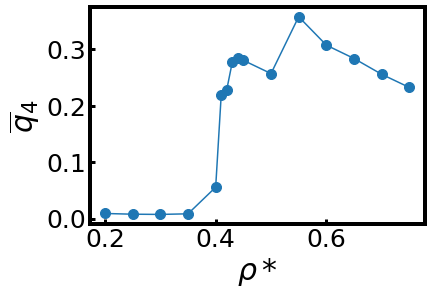

In [24]:
plt.plot(rho_list, q4_list, marker = 'o', markersize = 10)
plt.xlabel(r'$\rho*$')
plt.ylabel(r'$\overline{q}_4$')
plt.show()
plt.close()